In [1]:
!pip install gym

Homework 3 submission for Nirja Oak (ID: 964236111) and Anushka Deshpande (ID: 934381971)


##The T-maze environment

The TMazeEnv1 environment represents a T-shaped maze where an agent (represented as a mouse) can navigate. Here's a description of the maze environment:

The maze is represented as a 15x15 grid, with walls and open spaces.
The mouse (agent) is initially placed at a specific location within the maze (specified as (mouse_row, mouse_col)).


The mouse can take actions to move in different directions: straight, left, or right. These actions are represented as 0, 1, and 2, respectively.


The goal of the mouse is to reach either the leftmost cell in the second row ((1, 0)) or the rightmost cell in the second row ((1, 14)). These cells act as final reward locations.


The mouse receives rewards based on its current position and the presence of cues and the final reward locations.


Cues are randomly placed in the maze, either on the left side or the right side. The number of cues on each side is specified as n_cues_left and n_cues_right. The presence of cues affects the rewards obtained by the mouse.
If the number of cues on the left side is greater than the number of cues on the right side, the mouse receives a positive reward for cues on the left side and a negative reward for cues on the right side. If the number of cues on the right side is greater, the rewards are reversed.


The mouse can see the cues in the cells below its current position. If a cue is detected, the mouse receives the associated reward.


The maze is visualized using matplotlib, with the mouse, cues, and final reward locations displayed as different symbols on the grid.


Our hypothesis is that as the complexity of the task increases, that is the difference between number of cues on the left and right is decreased,the task would become harder.



In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
class TMazeEnv1(gym.Env):
    def __init__(self,rat=(14,7)):
        self.grid = np.ones((15, 15), dtype=float)
        self.grid[:, :6] = 0
        self.grid[:, 9:] = 0
        self.grid[:3, :] = 1
        self.action_space = spaces.Discrete(3)  # 0: straight, 1: left, 2: right

        self.observation_space = spaces.Discrete(3)  # 0: no cue, 1: cue on the left, 2: cue on the right
        #episode done flag
        self.done=False
        self.current_state = ()
        self.previous_state=()#to reestore the previous state in the render
        self.valid_actions=[]#contains all possible valid actions
        self.reward_loc = None#to assign a cell in the grid to be the reward location
        self.cue_loc_r=[]#to assign grid in the cell to be cue location
        self.cue_loc_l=[]
        #no of cues on the right or left
        self.n_cues_right=0
        self.n_cues_left=0
        #assign cue and final reward values
        self.cue_reward_l=0
        self.cue_reward_r=0
        self.no_of_rewards=0
        self.final_reward=5
        self.total_reward=0
        self.reward_flag=False
        #observation corridor and obervation reward
        self.obs_corridor_r=None
        self.obs_corridor_l=None
        self.obs_reward=None
        #valid actions aat decision point
        self.valid_action_decision=[]
        self.free_cells = [(r, 7) for r in range(1, 15)] + [(1, c) for c in range(15)]
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")

        self.reset(rat,self.n_cues_left,self.n_cues_right)
    def valid_actions(self):
        rat_row, rat_col = self.current_state
        self.valid_action_corridor=0
        self.valid_action_decision=[1,2]
        self.valid_action_left=1
        self.valid_action_right=2



        return self.valid_actions
    def get_state_matrix(self):
        state_matrix = np.copy(self.grid[3:15, 7])
        return state_matrix

    def reset(self,rat,n_cues_right,n_cues_left):

            self.rat = rat
            self.grid = np.ones((15, 15), dtype=float)
            self.grid[:, :6] = 0
            self.grid[:, 9:] = 0
            self.grid[:3, :] = 1
            #reset rewards


            self.total_reward=0
            self.reward_flag=False

            nrows, ncols = self.grid.shape
            row, col = rat
            self.current_state = (row, col)
            self.previous_state=(0,0)
            self.n_cues_right = n_cues_right
            self.n_cues_left = n_cues_left
            self.no_of_rewards=self.n_cues_right+self.n_cues_left
            self.cue_loc_r = []
            self.cue_loc_l = []
            #if the no of cues is greater on the left than right then thats where the ultimate reward is
            if  self.n_cues_left>self.n_cues_right:
                self.reward_loc=[1,0]
               #cues on the left are assigned a positive reward
                self.cue_reward_l=1
                self.cue_reward_r=-1
            else:
                self.reward_loc=[1,14]
                #cues on the right are assigned a positive reward
                self.cue_reward_l=-1
                self.cue_reward_r=+1
            self.valid_cells_rows_l = random.sample(range(3, 15), self.n_cues_left)
            self.cue_loc_l= [(r, 6) for r in self.valid_cells_rows_l]
            self.valid_cells_rows_r = random.sample(range(3, 15), self.n_cues_right)
            self.cue_loc_r= [(r, 8) for r in self.valid_cells_rows_r]






    def get_reward(self):
      rat_row, rat_col = self.current_state
      total_reward = np.zeros(self.no_of_rewards + 2)  # Create zero-filled reward vector

      if rat_row >= 2 and rat_row < 15:
          for i in range(len(self.cue_loc_l)):
              cue_l_row, cue_l_col = self.cue_loc_l[i]
              if cue_l_row - rat_row == 1:
                  total_reward[i] += self.cue_reward_l  # Add cue reward to the corresponding dimension

          for i in range(len(self.cue_loc_r)):
              cue_r_row, cue_r_col = self.cue_loc_r[i]
              if cue_r_row - rat_row == 1:
                  total_reward[i + len(self.cue_loc_l)] += self.cue_reward_r  # Add cue reward to the corresponding dimension

      if rat_row == 1 and rat_col == 0:
          total_reward[-1] += self.final_reward  # Add final reward to the last dimension
          self.reward_flag = True
      elif rat_row == 1 and rat_col == 14:
          total_reward[-1] += self.final_reward  # Add final reward to the last dimension
          self.reward_flag = True

      return total_reward


    def step(self, action):
        row, col = self.current_state
        row_prev=0
        col_prev=0
        if row==2 and col==7:
              row_prev=2
              col_prev=7



              if action==1:

                col-=1
                row-=1


              if action==2:

                col+=1
                row-=1

              if action==0:
                print("invalid action")



        elif row==1 and 0<col<=7:

            col-=1
            col_prev=col+1
            row_prev=1

        elif row==1 and 7<=col<15:

            col+=1
            col_prev=col-1
            row_prev=1

        elif col==7 and 1<=row<=14:

            row -= 1
            row_prev=row+1
            col_prev=7


        self.previous_state=(row_prev,col_prev)
        self.current_state = (row, col)
        self.done = False
        reward = self.get_reward()

        if self.current_state==(1,0) or   self.current_state==(1,14):
            self.done = True

        return self.grid, self.current_state[0], self.current_state[1], reward, self.done  #return observation, reward, done, {}




    def render(self, mode='human'):

        row, col = self.current_state
        row_prev,col_prev=self.previous_state
        self.grid[row,col]=0#rat
        self.grid[row_prev,col_prev]=1
        row_reward,column_reward=self.reward_loc
        self.grid[row_reward,column_reward]=0.3#reward cell
        for i in range(len(self.cue_loc_l)):#go over the list of cue locations on left and add rewrad
              cur_l_row,cue_l_col=self.cue_loc_l[i]
              self.grid[cur_l_row,cue_l_col]=0.7

        for i in range(len(self.cue_loc_r)):#go over the list of cue locations on left and add rewrad
              cur_r_row,cue_r_col=self.cue_loc_r[i]
              self.grid[cur_r_row,cue_r_col]=0.7


        plt.imshow(self.grid, cmap='gray')
        plt.axis('off')
        plt.savefig('maze_image.png')
        plt.show()





In [3]:
from gym.envs.registration import register


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
register(
    id='TMaze-v1',
    entry_point='tmaze_env:TMazeEnv1',  # Replace 'custom_env' with the name of the file containing the TMazeEnv class
)


Lets first initialize a random agent and render the environment

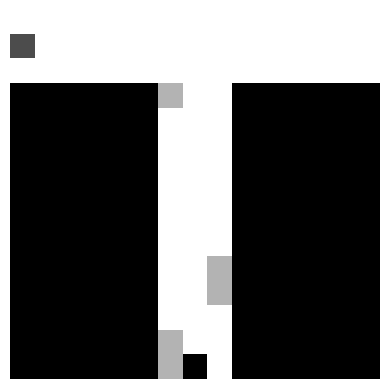

Row: 13 Col: 7 Reward: [1. 0. 0. 0. 0. 0. 0.]


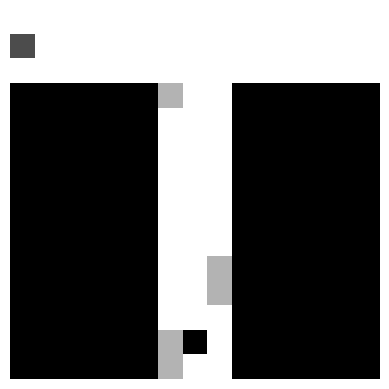

Row: 12 Col: 7 Reward: [0. 1. 0. 0. 0. 0. 0.]


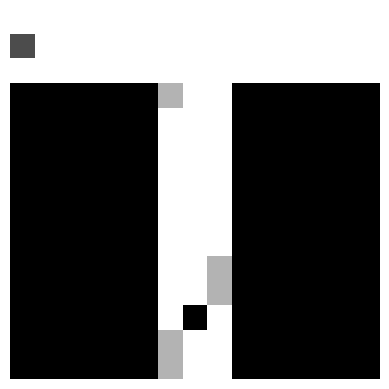

Row: 11 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


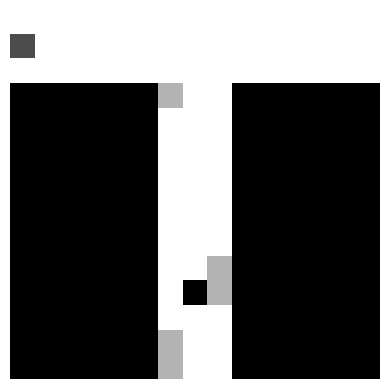

Row: 10 Col: 7 Reward: [ 0.  0.  0. -1.  0.  0.  0.]


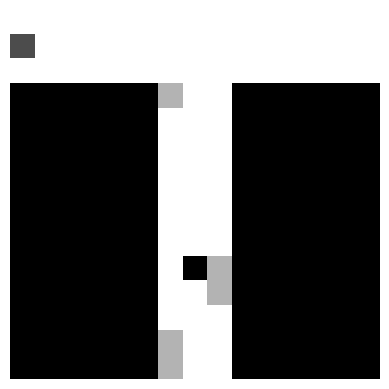

Row: 9 Col: 7 Reward: [ 0.  0.  0.  0. -1.  0.  0.]


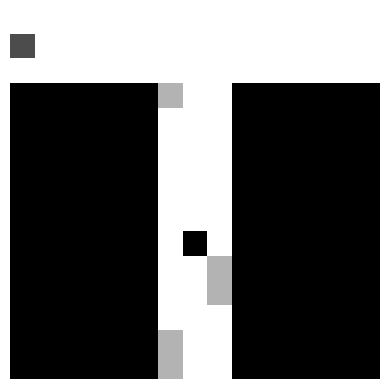

Row: 8 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


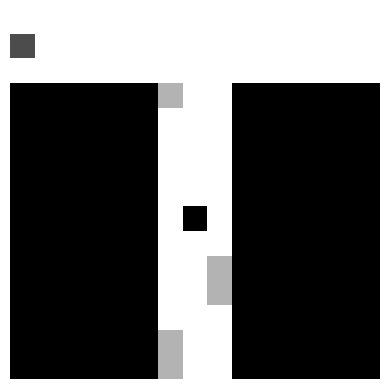

Row: 7 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


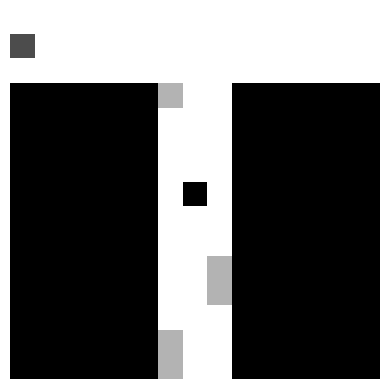

Row: 6 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


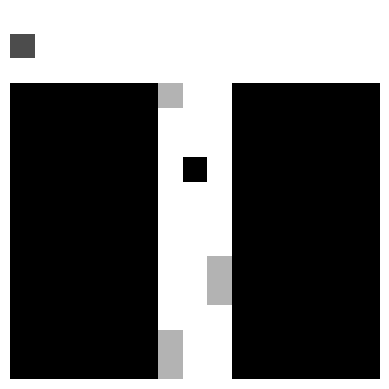

Row: 5 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


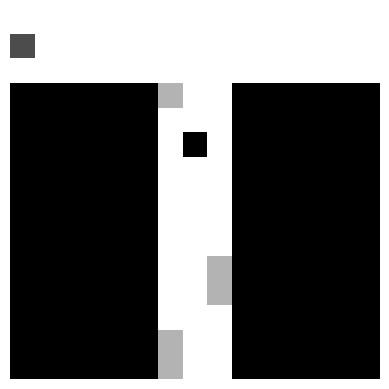

Row: 4 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


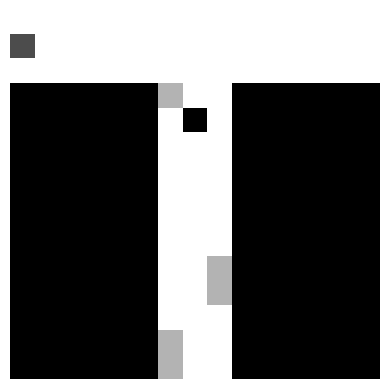

Row: 3 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


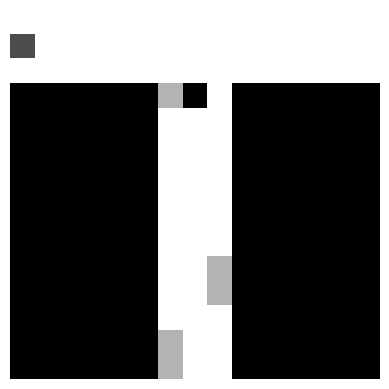

Row: 2 Col: 7 Reward: [0. 0. 1. 0. 0. 0. 0.]


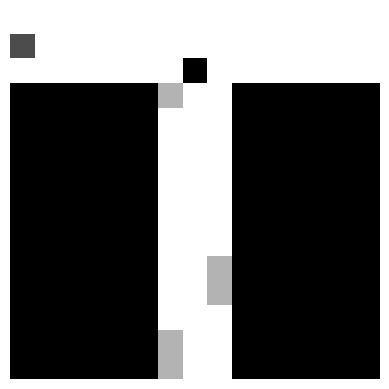

Taking decision
Action: 1
Row: 1 Col: 6 Reward: [0. 0. 0. 0. 0. 0. 0.]


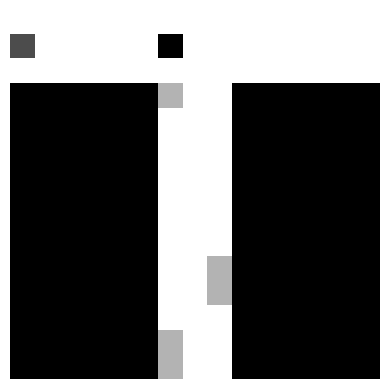

Row: 1 Col: 5 Reward: [0. 0. 0. 0. 0. 0. 0.]


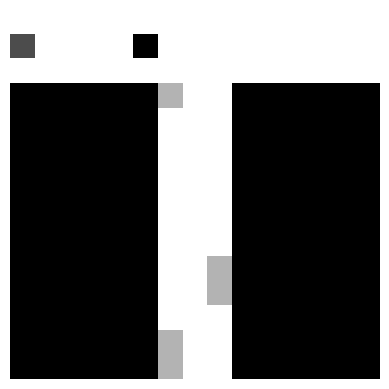

Row: 1 Col: 4 Reward: [0. 0. 0. 0. 0. 0. 0.]


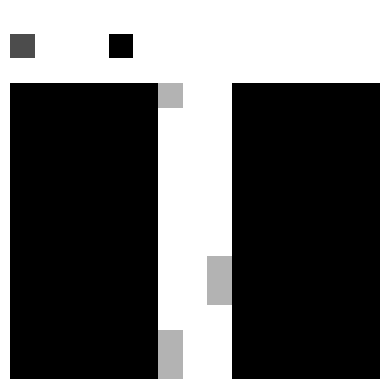

Row: 1 Col: 3 Reward: [0. 0. 0. 0. 0. 0. 0.]


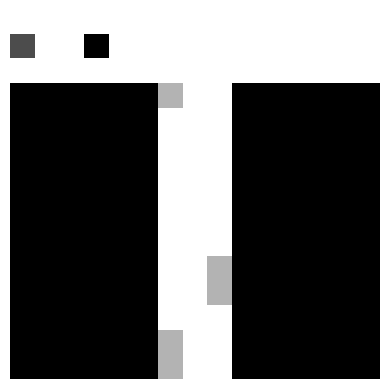

Row: 1 Col: 2 Reward: [0. 0. 0. 0. 0. 0. 0.]


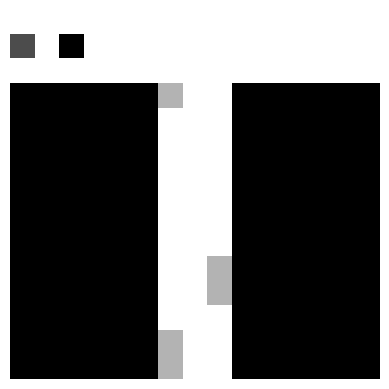

Row: 1 Col: 1 Reward: [0. 0. 0. 0. 0. 0. 0.]


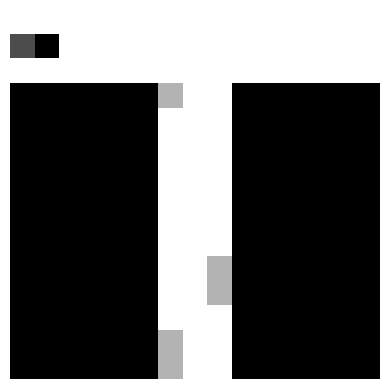

Row: 1 Col: 0 Reward: [0. 0. 0. 0. 0. 0. 5.]
Episode 1 completed.
Final Reward: [0. 0. 0. 0. 0. 0. 5.]


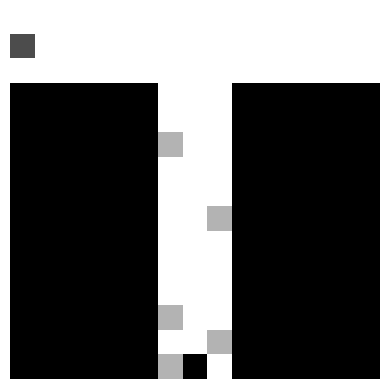

Row: 13 Col: 7 Reward: [1. 0. 0. 0. 0. 0. 0.]


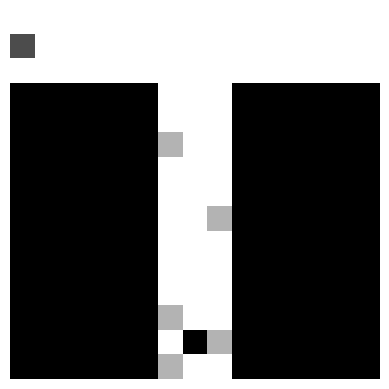

Row: 12 Col: 7 Reward: [ 0.  0.  0. -1.  0.  0.  0.]


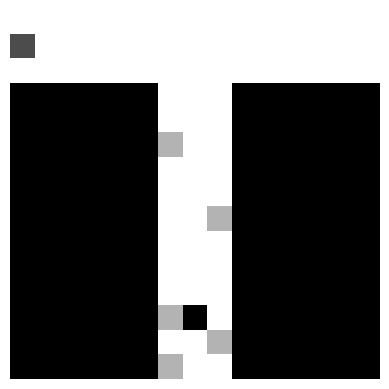

Row: 11 Col: 7 Reward: [0. 1. 0. 0. 0. 0. 0.]


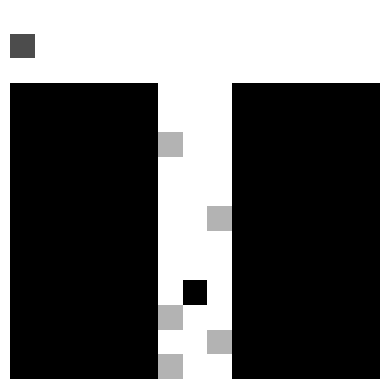

Row: 10 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


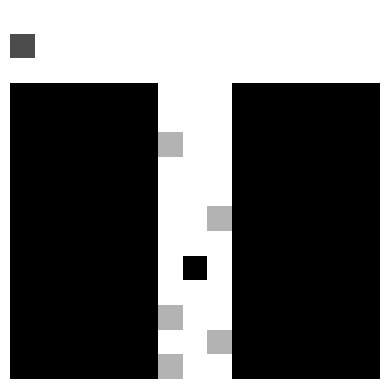

Row: 9 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


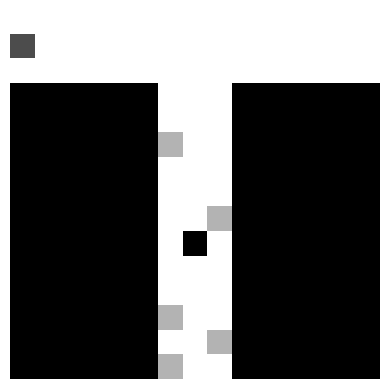

Row: 8 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


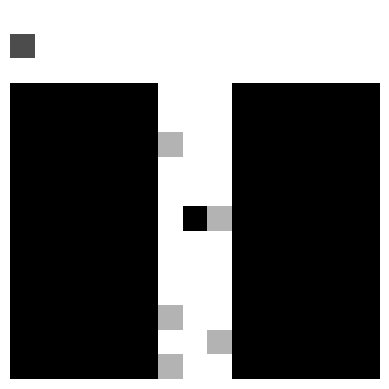

Row: 7 Col: 7 Reward: [ 0.  0.  0.  0. -1.  0.  0.]


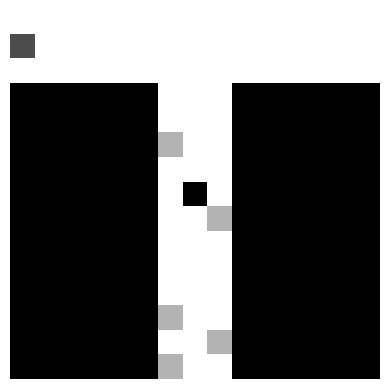

Row: 6 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


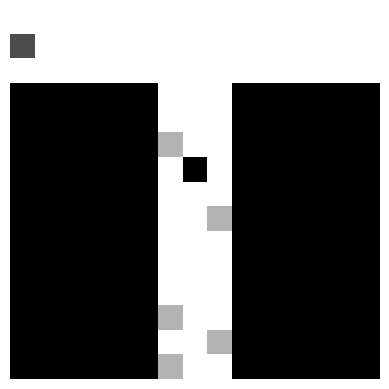

Row: 5 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


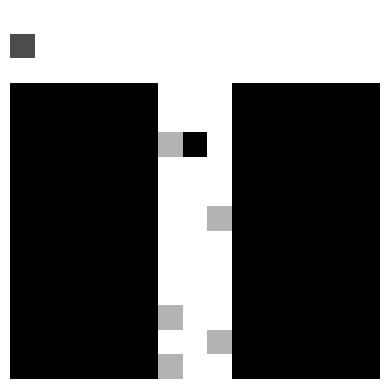

Row: 4 Col: 7 Reward: [0. 0. 1. 0. 0. 0. 0.]


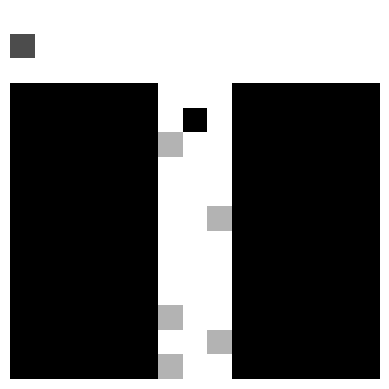

Row: 3 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


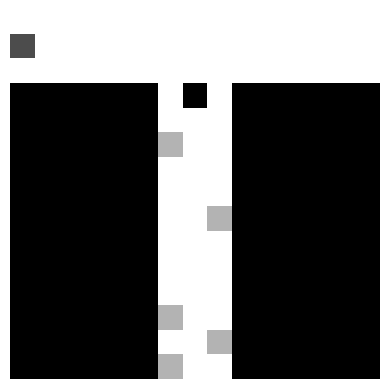

Row: 2 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


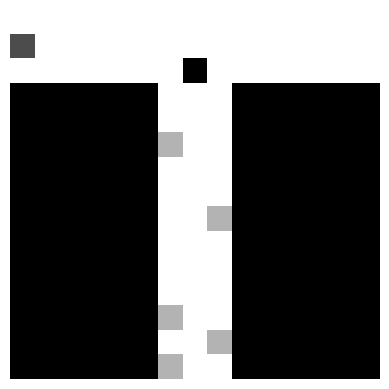

Taking decision
Action: 2
Row: 1 Col: 8 Reward: [0. 0. 0. 0. 0. 0. 0.]


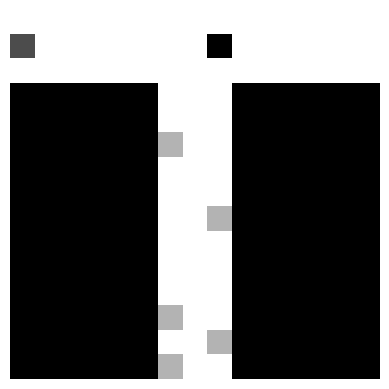

Row: 1 Col: 9 Reward: [0. 0. 0. 0. 0. 0. 0.]


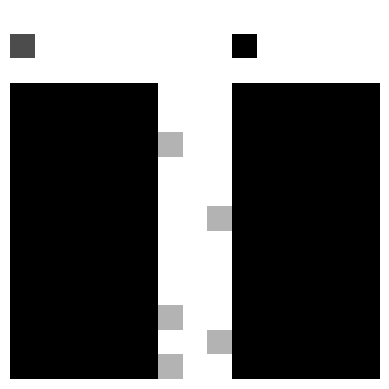

Row: 1 Col: 10 Reward: [0. 0. 0. 0. 0. 0. 0.]


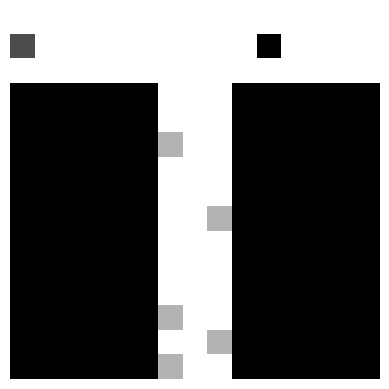

Row: 1 Col: 11 Reward: [0. 0. 0. 0. 0. 0. 0.]


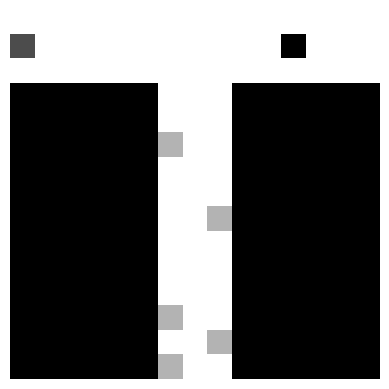

Row: 1 Col: 12 Reward: [0. 0. 0. 0. 0. 0. 0.]


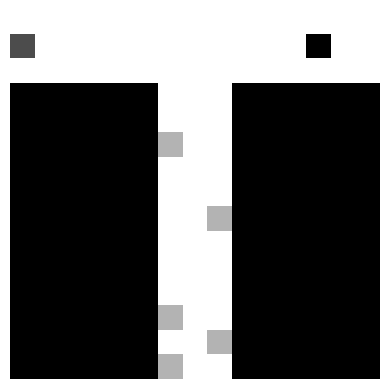

Row: 1 Col: 13 Reward: [0. 0. 0. 0. 0. 0. 0.]


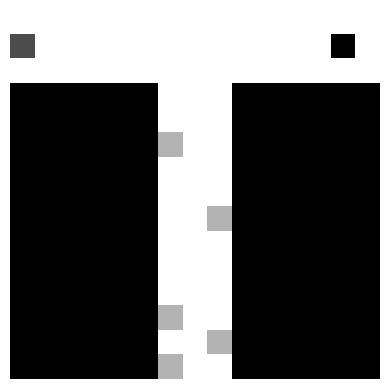

Row: 1 Col: 14 Reward: [0. 0. 0. 0. 0. 0. 5.]
Episode 2 completed.
Final Reward: [0. 0. 0. 0. 0. 0. 5.]


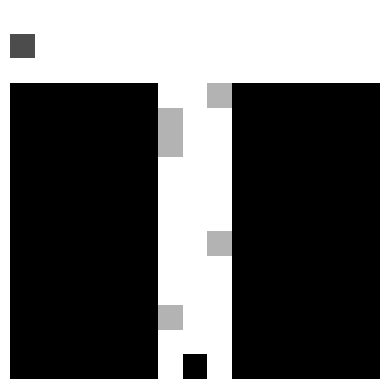

Row: 13 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


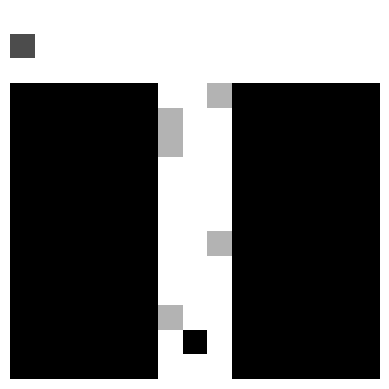

Row: 12 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


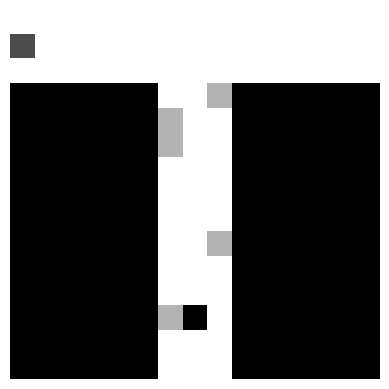

Row: 11 Col: 7 Reward: [0. 0. 1. 0. 0. 0. 0.]


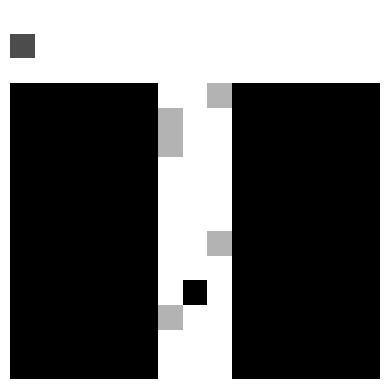

Row: 10 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


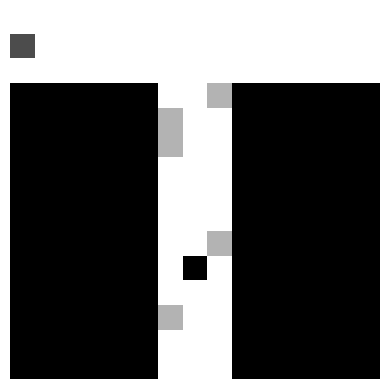

Row: 9 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


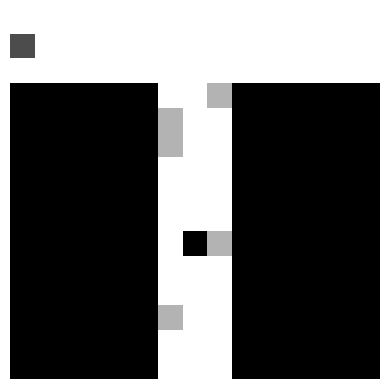

Row: 8 Col: 7 Reward: [ 0.  0.  0.  0. -1.  0.  0.]


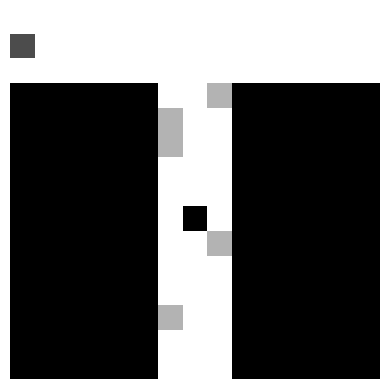

Row: 7 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


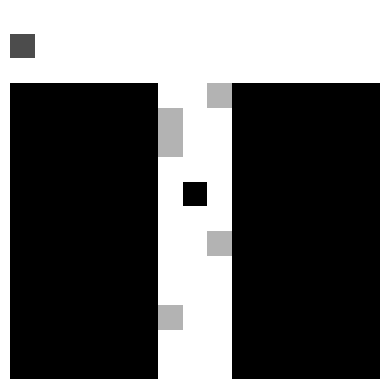

Row: 6 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


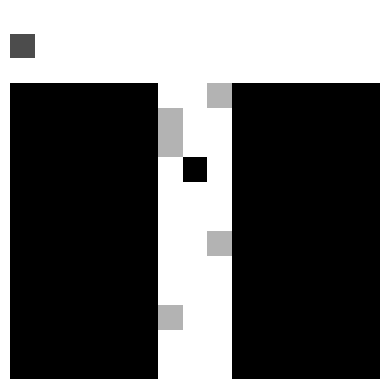

Row: 5 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


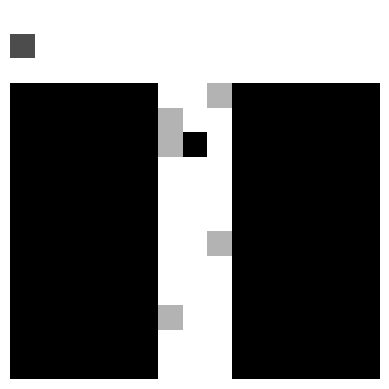

Row: 4 Col: 7 Reward: [0. 1. 0. 0. 0. 0. 0.]


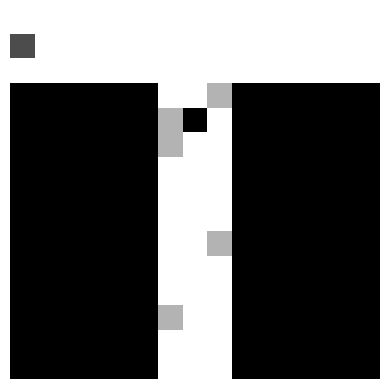

Row: 3 Col: 7 Reward: [1. 0. 0. 0. 0. 0. 0.]


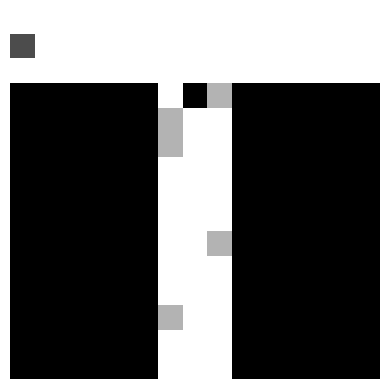

Row: 2 Col: 7 Reward: [ 0.  0.  0. -1.  0.  0.  0.]


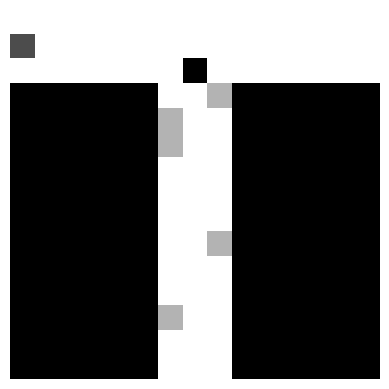

Taking decision
Action: 0
invalid action
Row: 2 Col: 7 Reward: [ 0.  0.  0. -1.  0.  0.  0.]


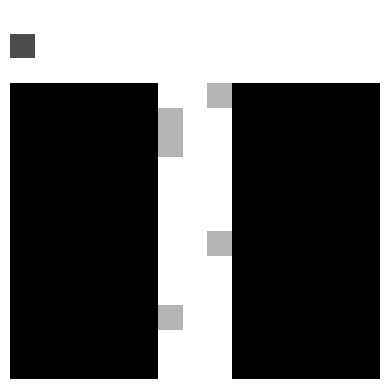

Taking decision
Action: 1
Row: 1 Col: 6 Reward: [0. 0. 0. 0. 0. 0. 0.]


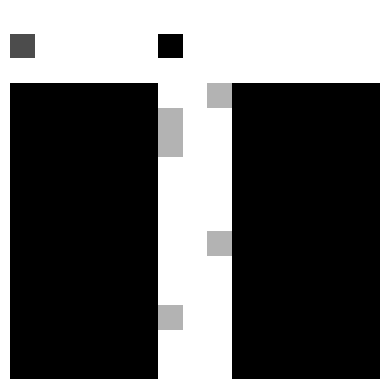

Row: 1 Col: 5 Reward: [0. 0. 0. 0. 0. 0. 0.]


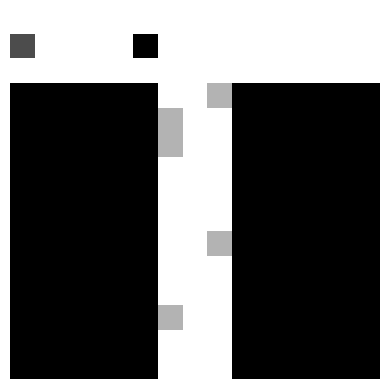

Row: 1 Col: 4 Reward: [0. 0. 0. 0. 0. 0. 0.]


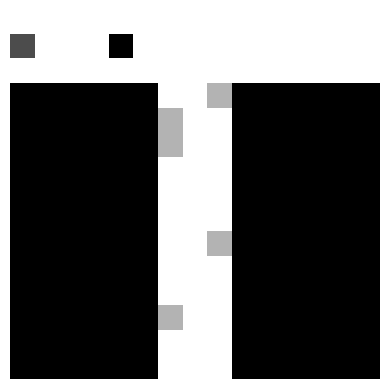

Row: 1 Col: 3 Reward: [0. 0. 0. 0. 0. 0. 0.]


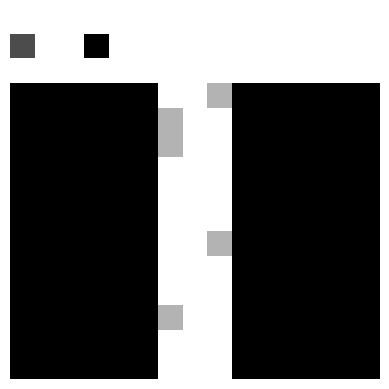

Row: 1 Col: 2 Reward: [0. 0. 0. 0. 0. 0. 0.]


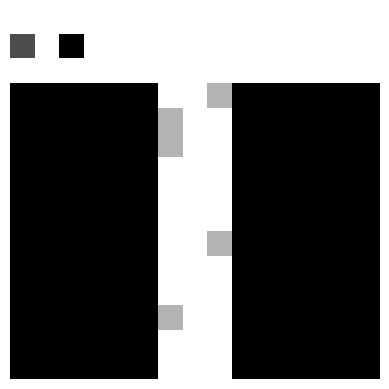

Row: 1 Col: 1 Reward: [0. 0. 0. 0. 0. 0. 0.]


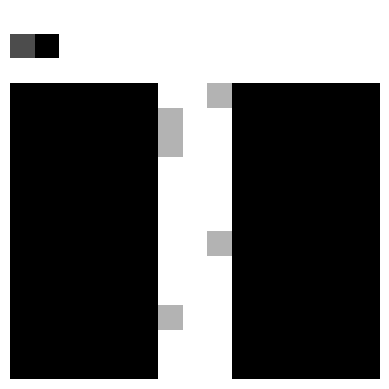

Row: 1 Col: 0 Reward: [0. 0. 0. 0. 0. 0. 5.]
Episode 3 completed.
Final Reward: [0. 0. 0. 0. 0. 0. 5.]


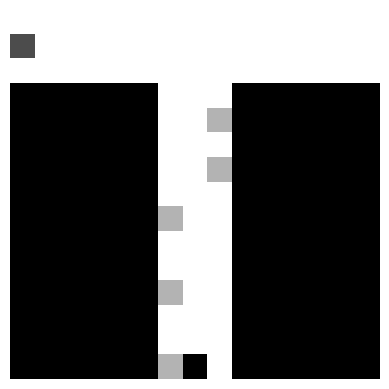

Row: 13 Col: 7 Reward: [0. 0. 1. 0. 0. 0. 0.]


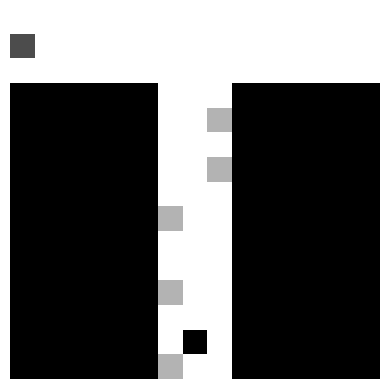

Row: 12 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


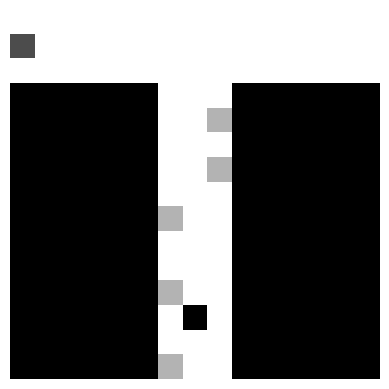

Row: 11 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


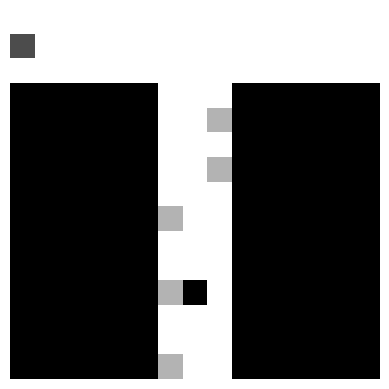

Row: 10 Col: 7 Reward: [0. 1. 0. 0. 0. 0. 0.]


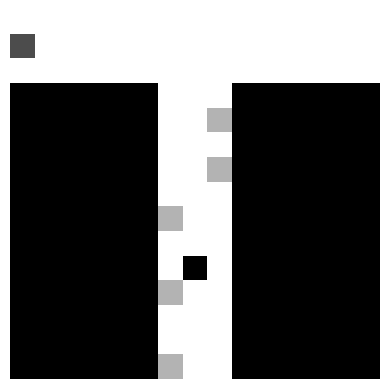

Row: 9 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


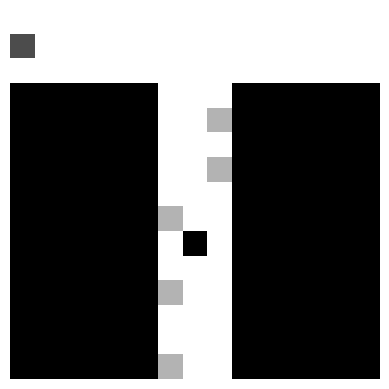

Row: 8 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


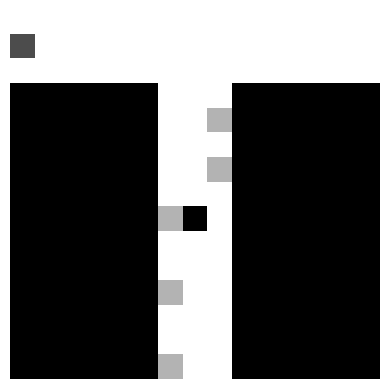

Row: 7 Col: 7 Reward: [1. 0. 0. 0. 0. 0. 0.]


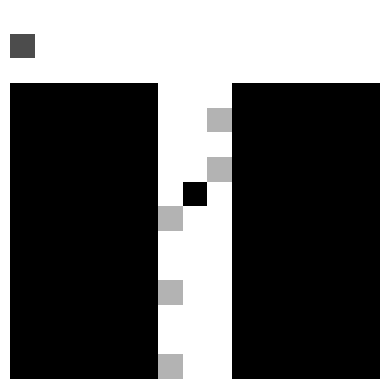

Row: 6 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


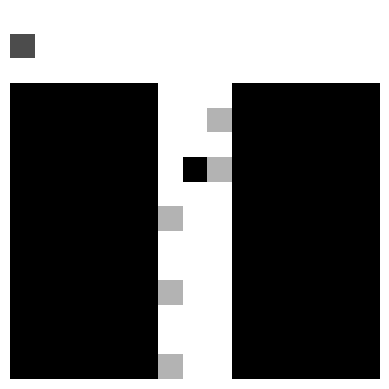

Row: 5 Col: 7 Reward: [ 0.  0.  0. -1.  0.  0.  0.]


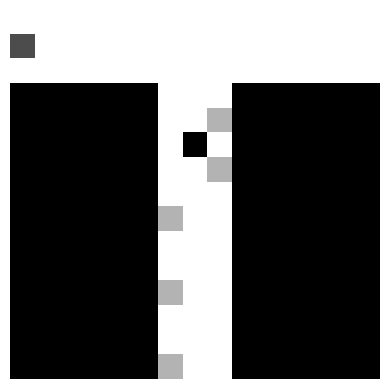

Row: 4 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


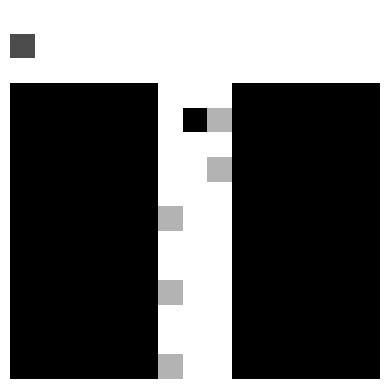

Row: 3 Col: 7 Reward: [ 0.  0.  0.  0. -1.  0.  0.]


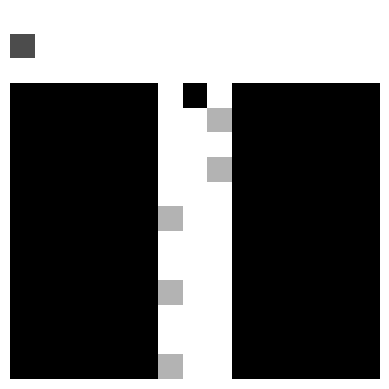

Row: 2 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


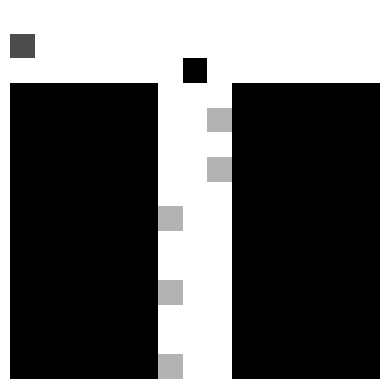

Taking decision
Action: 0
invalid action
Row: 2 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


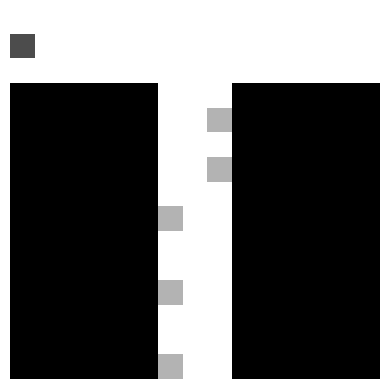

Taking decision
Action: 1
Row: 1 Col: 6 Reward: [0. 0. 0. 0. 0. 0. 0.]


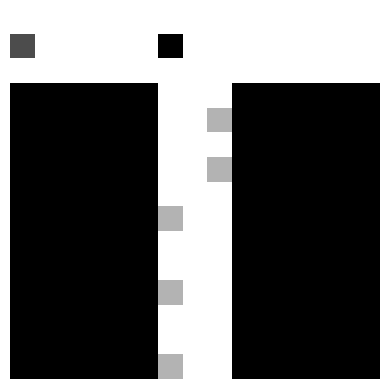

Row: 1 Col: 5 Reward: [0. 0. 0. 0. 0. 0. 0.]


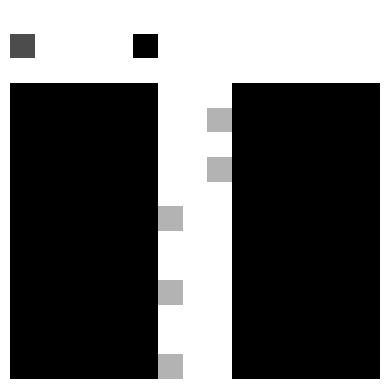

Row: 1 Col: 4 Reward: [0. 0. 0. 0. 0. 0. 0.]


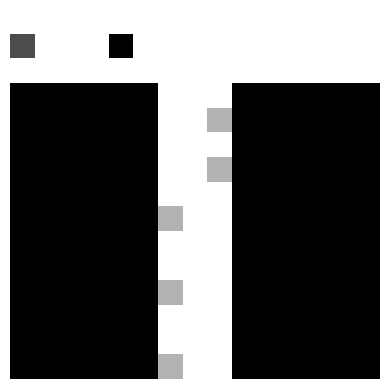

Row: 1 Col: 3 Reward: [0. 0. 0. 0. 0. 0. 0.]


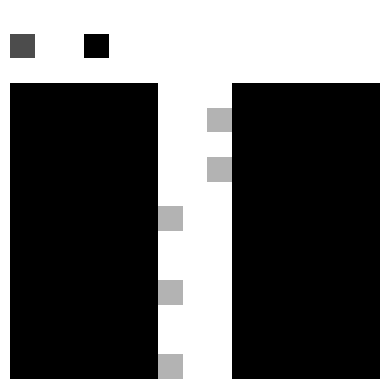

Row: 1 Col: 2 Reward: [0. 0. 0. 0. 0. 0. 0.]


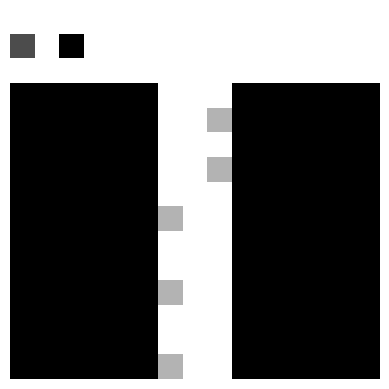

Row: 1 Col: 1 Reward: [0. 0. 0. 0. 0. 0. 0.]


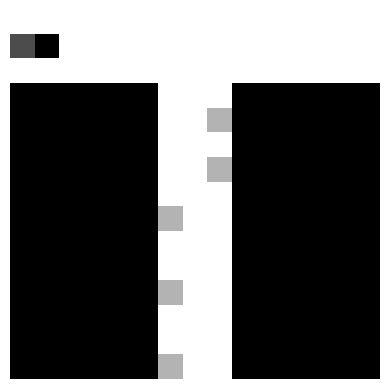

Row: 1 Col: 0 Reward: [0. 0. 0. 0. 0. 0. 5.]
Episode 4 completed.
Final Reward: [0. 0. 0. 0. 0. 0. 5.]


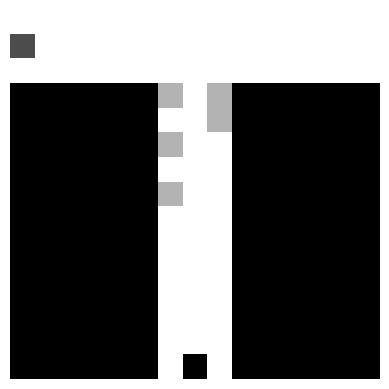

Row: 13 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


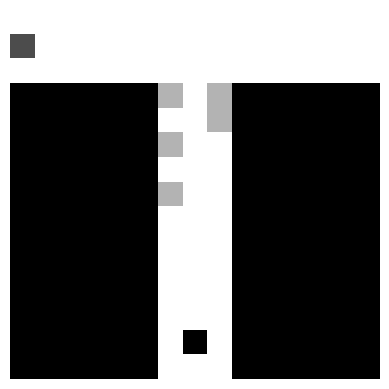

Row: 12 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


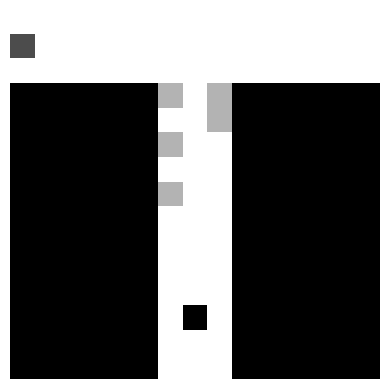

Row: 11 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


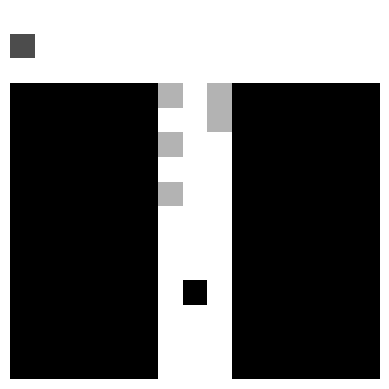

Row: 10 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


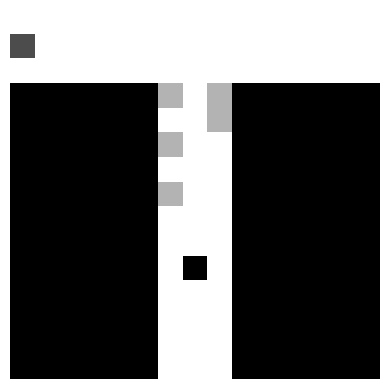

Row: 9 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


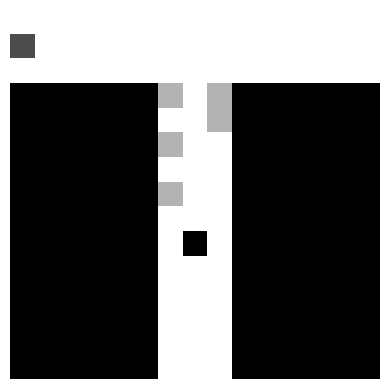

Row: 8 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


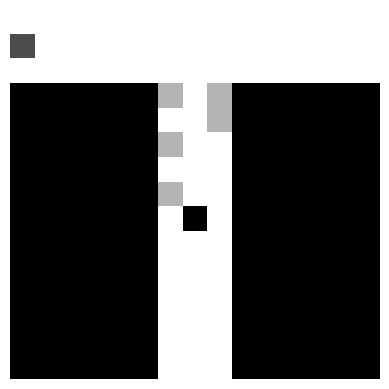

Row: 7 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


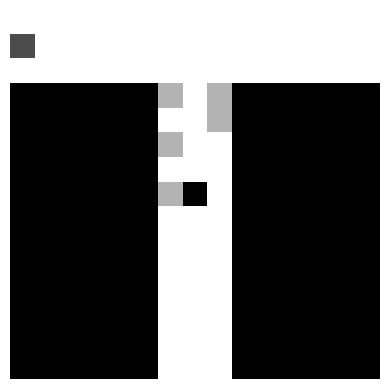

Row: 6 Col: 7 Reward: [1. 0. 0. 0. 0. 0. 0.]


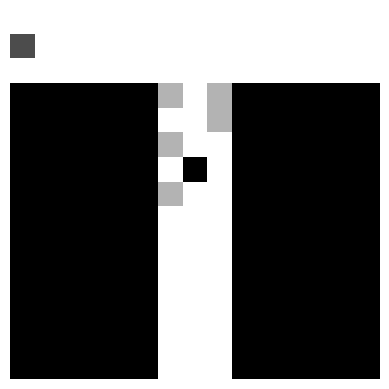

Row: 5 Col: 7 Reward: [0. 0. 0. 0. 0. 0. 0.]


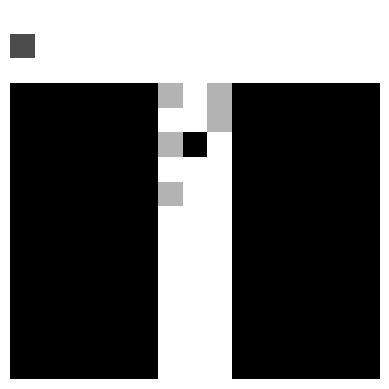

Row: 4 Col: 7 Reward: [0. 1. 0. 0. 0. 0. 0.]


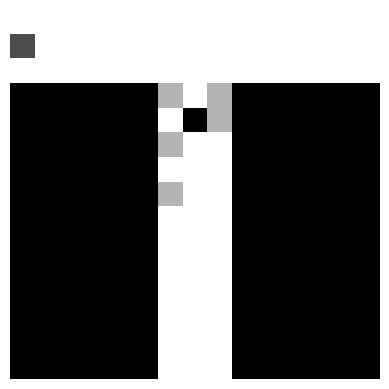

Row: 3 Col: 7 Reward: [ 0.  0.  0.  0. -1.  0.  0.]


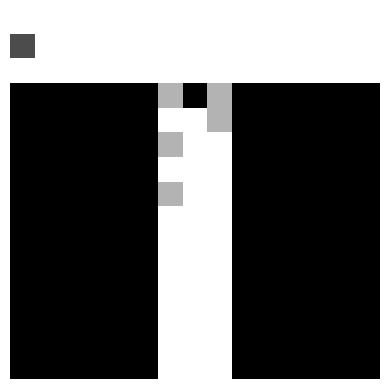

Row: 2 Col: 7 Reward: [ 0.  0.  1. -1.  0.  0.  0.]


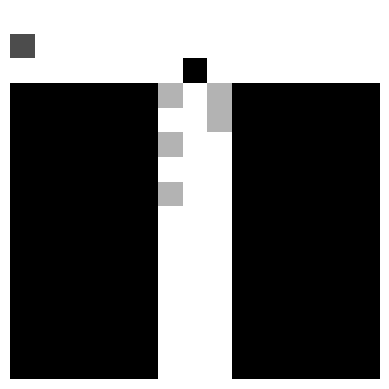

Taking decision
Action: 2
Row: 1 Col: 8 Reward: [0. 0. 0. 0. 0. 0. 0.]


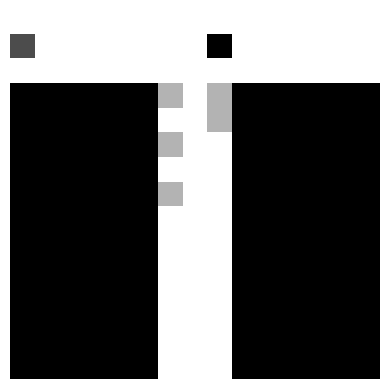

Row: 1 Col: 9 Reward: [0. 0. 0. 0. 0. 0. 0.]


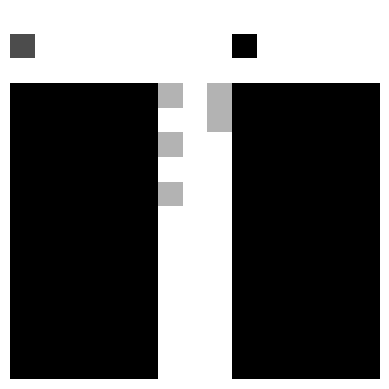

Row: 1 Col: 10 Reward: [0. 0. 0. 0. 0. 0. 0.]


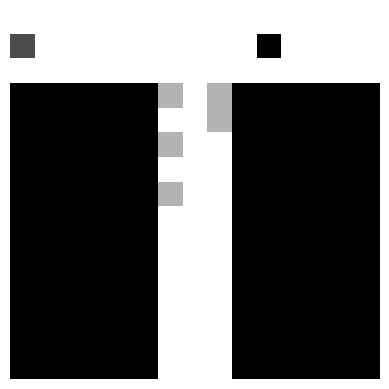

Row: 1 Col: 11 Reward: [0. 0. 0. 0. 0. 0. 0.]


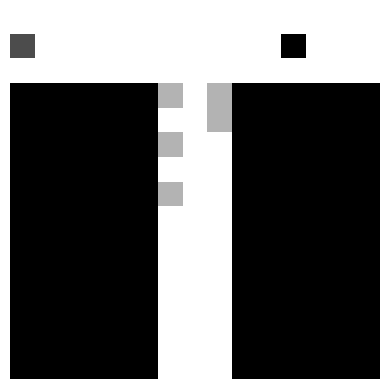

Row: 1 Col: 12 Reward: [0. 0. 0. 0. 0. 0. 0.]


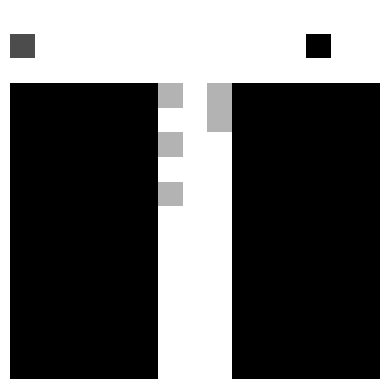

Row: 1 Col: 13 Reward: [0. 0. 0. 0. 0. 0. 0.]


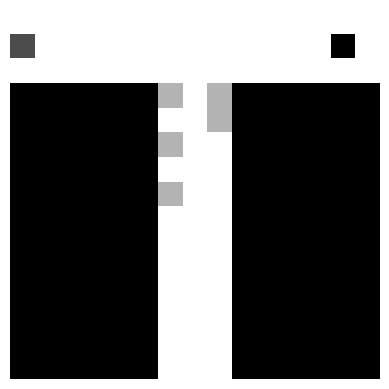

Row: 1 Col: 14 Reward: [0. 0. 0. 0. 0. 0. 5.]
Episode 5 completed.
Final Reward: [0. 0. 0. 0. 0. 0. 5.]
Total reward: [ 0.  0.  0.  0.  0.  0. 25.]


In [5]:
env = TMazeEnv1()  # Initialize the environment with your grid
totalr = 0

for episode in range(5):  # Run 10 episodes
    observation = env.reset(rat=(14, 7), n_cues_left=3, n_cues_right=2)  # Reset the environment and set the rat at position (14, 7)
    done = False
    row = 14
    col = 7
    action=1
    while not done:
        env.render()
        if row == 2 and col == 7:
            print("Taking decision")
              # Render the current state of the environment
            action = env.action_space.sample()  # Choose a random action
            print("Action:", action)

        observation, row, col, reward, done = env.step(action)  # Take a step in the environment
        print("Row:", row, "Col:", col, "Reward:", reward)


    print("Episode", episode + 1, "completed.")
    print("Final Reward:", reward)
    totalr += reward

print("Total reward:", totalr)


##Q learning

####Overview of q learning

Q-learning is a reinforcement learning algorithm used to find the optimal policy for decision-making in an environment. It maintains a Q-table that stores the expected cumulative rewards for each state-action pair. The algorithm iteratively updates the Q-values based on observed rewards and the maximum Q-value of the next state. This process gradually converges to the optimal Q-values, enabling the agent to make informed decisions. The Q-values guide the agent's policy, determining the best actions to take in each state.

###How it works

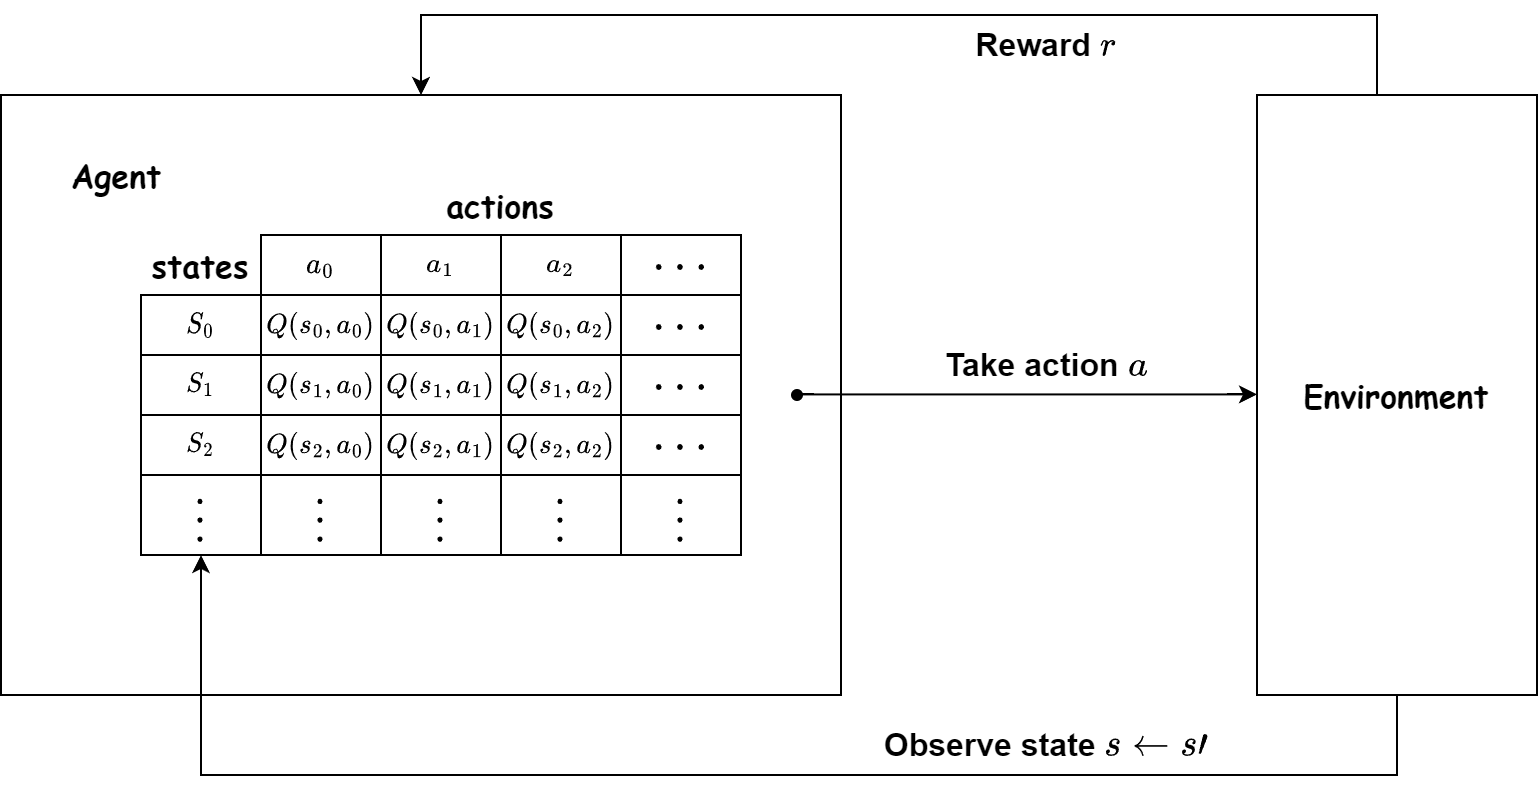


The Q-table is a tabular representation of the Q-values for each state-action pair in a reinforcement learning problem. It is updated during the Q-learning process. Each cell in the table represents the Q-value for a specific state-action pair. The Q-value represents the expected cumulative reward an agent can achieve by taking a particular action in a given state and following an optimal policy thereafter. The Q-table can be represented using LaTeX as follows:



Here, $Q(s,a)$ represents the Q-value for state $s$ and action $a$. For example, $Q(1,1)$ represents the Q-value for State 1 and Action 1.



###Epsilon-Greedy Policy:

The epsilon-greedy policy is a strategy used to balance exploration and exploitation in reinforcement learning. It determines how the agent selects actions based on the Q-values in the Q-table. The policy selects the action with the highest Q-value (exploitation) most of the time, but occasionally chooses a random action (exploration) to explore other possibilities.

The epsilon-greedy policy can be defined using the following equations:

\begin{equation*}
\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}, & \text{if } a = \text{argmax}_a Q(s,a) \
\frac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}
\end{cases}
\end{equation*}

Here, $\pi(a|s)$ represents the probability of selecting action $a$ in state $s$. $|\mathcal{A}|$ represents the total number of possible actions. The parameter $\epsilon$ controls the exploration-exploitation trade-off. If $a$ is the action with the highest Q-value, the probability of selecting $a$ is $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}$. Otherwise, the probability of selecting $a$ is $\frac{\epsilon}{|\mathcal{A}|}$.

The epsilon-greedy policy ensures that the agent mostly selects the action with the highest Q-value, but with a small probability $\epsilon$, it explores other actions by selecting them randomly.

###The relationship of q learning and dopamine


The theory and data available today indicate that the phasic activity of midbrain dopamine neurons encodes a reward prediction error used to guide learning throughout the frontal cortex and the basal ganglia. Activity in these dopaminergic neurons is now believed to signal that a subject's estimate of the value of current and future events is in error and indicate the magnitude of this error. This is a kind of combined signal that most scholars active in dopamine studies believe adjusts synaptic strengths in a quantitative manner until the subject's estimate of the value of current and future events is accurately encoded in the frontal cortex and basal ganglia



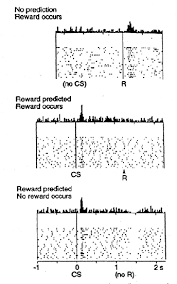

###SIMULATING CA2+ ACTIVITY

 the calcium concentration at time t depends on the previous p time steps, with p being the order of the autoregressive (AR) model. The AR model equation is defined as:

c(t) = ∑(j=1)^(p) γ_j c(t-j) + s(t)

Where:

𝑐(𝑡) represents the calcium concentration at time t.


𝛾_𝑗 represents the autoregression coefficient for the j-th previous time step.


𝑝 is the order of the AR model, indicating the number of previous time steps considered.


𝑠(𝑡) represents the sum of spikes in a given time interval, contributing to the calcium concentration at time t.


The model assumes that the calcium concentration is influenced by the previous p time steps, and the autoregression coefficients 𝛾_𝑗 determine the contribution of each previous time step to the current concentration. The parameter p determines the dynamics of the rise in calcium concentration. A lower p value (e.g., p = 1) implies an instantaneous increase in calcium concentration, while a higher p value (e.g., p = 2) captures more detailed rise dynamics.



Knowing that lets now implement a q learning agent who uses an epsilon greedy strategy

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action between 1 and 2
        return env.action_space.sample()
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q) +1

In [7]:
num_episodes=100#thousand episodes is like stimulating a thousand neurons

# Define the TD learning parameters
alpha = 0.001  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.7  # Epsilon for epsilon-greedy strategy
decay_rate=0.95

In [8]:
!pip install opencv-python-headless
import cv2



Lets first perform a fairly easy task where there is only a single cue on the right indicating the reward is on the right.We want to check the total cumulative reward and TD error for this task

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import os
import matplotlib.colors as mlp_colors
from IPython.display import HTML,clear_output
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import tensorflow as tf
class DQN:
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.model = self.create_model()

    def create_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, input_shape=(self.state_dim,), activation='relu'),
            tf.keras.layers.Dense(self.hidden_dim, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
        return model

    def update(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)

    def get_q_values(self, state):
        state = tf.expand_dims(state, axis=0)  # Expand dimensions to match model input shape
        return self.model.predict(state)[0]

class DQNAgent:
    def __init__(self, gamma=0.9, epsilon=0.7, epsilon_decay_rate=0.9):
        self.env = TMazeEnv1()
        self.state_dim = 2 #  STATE IS LOCATION OF THE MOUSE=(ROW,COL) from 14,7 to 2,7
        self.action_dim = 2  # assuming the environment provides action dimension
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.dqn = DQN(self.state_dim, self.action_dim)

    """
    def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action between 1 and 2
        return env.action_space.sample()
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q) +1
    """

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # take a random action
        else:
            q_values = self.dqn.get_q_values(state)
            return np.argmax(q_values)+1  # take the best action

    def run_episodes(self, n_cues_left, n_cues_right):
        Q = np.zeros(2)
        reward_dim = n_cues_left + n_cues_right + 2
        # Define the TD learning parameters
        alpha = 0.1  # Learning rate
        gamma = 0.9  # Discount factor
        epsilon = 0.7  # Epsilon for epsilon-greedy strategy
        decay_rate=0.9

        num_steps = 18  # Assuming a corridor length of 13 steps
        num_episodes = 50  # Set the number of episodes
        avg_td_errors = np.zeros(num_steps)
        td_errors1 = []
        td_error = 0#it will have memory of all previous td error s this makes sense
        tderror_tracker = np.zeros((19, num_episodes))
        reward_arr = np.zeros(reward_dim)#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes
        reward_t1 = []
        action_history1 = []
        action=0
        total_rewards=[]
        td_error_matrix = np.zeros((num_episodes, reward_dim))
        multi_td_per_step = np.zeros((reward_dim,num_steps+2))
        multi_td_per_step_per_episode = np.zeros((reward_dim,num_steps+2,num_episodes))
        multi_td=np.zeros((reward_dim))

        for episode in range(num_episodes):

            print("EPISODE",episode)
            # Reset the environment and set the rat at position (14, 7)
            observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
            done = False
            row = 14
            col = 7
            step = 0  # Track the step number
            reward_t1 = []
            td_errors1 = []
            multi_td0=[]


            episode_action_history = []  # Action history for the current episode
            total_reward=0
            state=[]
            next_state=[13,7]
            next_state_array=np.array(next_state)
            reward_arr = np.zeros(reward_dim)
            next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
            next_q_values = self.dqn.get_q_values(next_state)
            multid_td_error=np.zeros(reward_dim)
            multid_td_error = np.zeros(reward_dim)
            multi_td_per_step = np.zeros((reward_dim,num_steps+2))
            while not done:
                #env.render()
                state=[row,col]
                state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
                q_tensor = tf.convert_to_tensor(Q, dtype=tf.float32)
                q_values = self.dqn.get_q_values(state_tensor)
                state_array=np.array(state)
                q_array=np.array(Q)
                if row == 2 and col == 7:
                  action = self.epsilon_greedy(state_tensor)
                  episode_action_history.append(action)

                else:

                  for dim in range(reward_dim-2):
                    if reward_arr[dim] != 0:
                      print("dim",dim)
                      multid_td_error[dim] = reward_arr[dim] + gamma * np.max(next_q_values) - q_values[action - 1]
                      print("multi td",multid_td_error)
                      self.dqn.update(state_array.reshape(1, -1), q_array.reshape(1, -1))
                observation, row, col, reward, done = env.step(action)
                reward_arr=reward
                next_state=[row,col]
                next_state_array=np.array(next_state)

                next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
                next_q_values = self.dqn.get_q_values(next_state)
                #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)
                multid_td_error[reward_dim-2] = reward[reward_dim-2] + self.gamma * np.max(next_q_values) - q_values[ action - 1]  # Calculate the TD error
                #Q[action - 1] += alpha * td_error  # Update the Q-value for the current action
                #i am not using the td error to make the updates here as the neural network has an update func
                self.dqn.update(state_array.reshape(1, -1), q_array.reshape(1, -1))

                td_errors1.append(td_error)  # Append the TD error to the list
                reward_t1.append(reward)
                action_history1.append(episode_action_history)
                multid_td_error[reward_dim-1] = np.mean(np.array(reward_t1[-1:]))


                multi_td=multid_td_error
                multi_td_per_step[:, step]=multi_td.reshape(-1)
                rd_error = 0
                reward = 0
                step+=1

            multi_td_per_step_per_episode[:,:,episode]=multi_td_per_step

            #tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
            self.epsilon *= self.epsilon_decay_rate
            total_rewards.append(sum(reward_t1))
            td_error_matrix[episode] = multid_td_error#matrix of multi dimensional td error

        print("multi_td",multi_td)
        #Calculate the average TD error for each step
        avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
        avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
        avg_multid_td_errors=np.mean(td_error_matrix, axis=0)
        avg_multi_td_per_step_per_episode=np.mean( multi_td_per_step_per_episode,axis=2)

        print("TOTAL multi  REWARD", np.sum(avg_multid_td_errors))





        # Plot the multi TD error data
        column_index = 0
        plt.figure()
        for i in range(reward_dim):
            plt.figure()
            plt.plot(range(num_episodes), td_error_matrix[:, i], label=f'ELEMENT {i}')
            plt.xlabel('Episode')
            plt.ylabel('TD Error')
            plt.title(f'TD Error for Element {i} of vector RPE')
            plt.legend()
            plt.show()
        column_index = 0
        plt.figure()
        for i in range(reward_dim):
            plt.figure()
            plt.plot(range(num_steps+2), avg_multi_td_per_step_per_episode[i,:], label=f'ELEMENT {i}')
            plt.xlabel('Episode')
            plt.ylabel('TD Error')
            plt.title(f'TD Error for Element {i} of vector RPE')
            plt.legend()
            plt.show()
        noise_level=0.1
        num_neurons = tderror_tracker.shape[0]
        gcamp_kernel = np.random.rand(num_neurons)
        fluorescence_episode = []
        delta_fluorescence_traces=[1]
        total_fluorescence_traces=[]
        ratio=[]

        delta_fluorescence_traces = []
        total_fluorescence_traces = []
        time=tderror_tracker.shape[1]

        # AR Model Parameters
        #SIMULATING CALCIUM ACTIVITTY
        p = 1  # Order of the AR model
        gamma = np.linspace(0.1, 0.4, p)#the ar coeffiecient
        C_dt = 0.1
        nc = C_dt / time
        num_neurons=10
        calcium_concentration=np.zeros((reward_dim,num_steps+2))
        calcium_concentration_traces = np.zeros((reward_dim,num_steps+2,num_neurons))
        calcium_concentration_matrix = []

        ###a single neuron encodes a differnet element of vector rpe
        num_neurons=reward_dim

        for j in range(reward_dim):

            gamma_resized = np.resize(gamma, avg_multi_td_per_step_per_episode[j, :].shape)
            calcium_concentration[j,:] = (gamma_resized* avg_multi_td_per_step_per_episode[j,:]) + np.sum(avg_multi_td_per_step_per_episode[j,:]) * nc

        window_size = 3  # Adjust the window size as needed
        smoothed_calcium_concentration = np.zeros_like(calcium_concentration)
        for i in range(reward_dim):
          smoothed_calcium_concentration[i, :] = np.convolve(calcium_concentration[i, :], np.ones(window_size) / window_size, mode='same')


        plt.figure()

        for i in range(reward_dim):

            plt.plot(range(num_steps+2),  smoothed_calcium_concentration[i,:], label=f'ELEMENT {i}')
        plt.xlabel('Episode')
        plt.ylabel('Calcium concentration')
        plt.title(f'Calcium concentration  vs time')
        plt.legend()
        plt.show()
      ##SIMULATING and plotting THE FLOUROSCENT ACTIVITY
        num_neurons=reward_dim
        baseline = np.random.rand(num_neurons)  # Time-dependent baseline
        noise_mean = 0  # Mean of the Gaussian noise
        noise_std = 0.1  # Standard deviation of the Gaussian noise

        Neu_locs = np.random.rand(num_neurons, 2)  # Random neuron locations in 2D space
        NeuSize = 2  # Average size of neurons

        # Generate 2D Gaussian distribution for each neuron
        x, y = np.meshgrid(np.linspace(-num_neurons, num_neurons, 20), np.linspace(-num_neurons, num_neurons, 20))  # Grid of x and y coordinates

        combined_neuron_distributions = np.zeros((20 * num_neurons, 20 * num_neurons))  # Initialize combined neuron distribution array
        fluorescence_image = np.zeros_like(combined_neuron_distributions)

        fluorescence_array=[]
        fluorescence_cmap = mlp_colors.LinearSegmentedColormap.from_list('GreenToBlack', ['black', 'green'],N=256)
        fluorescence_norm = mlp_colors.Normalize(vmin=0, vmax=np.max(fluorescence_image))
        for i in range(num_neurons):
            sigma = NeuSize  # Random sigma from a normal distribution
            neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron

            fluorescence_per_neuron = np.dot(calcium_concentration , neuron_distribution)+ baseline[i]+np.random.normal(noise_mean, noise_std, size=calcium_concentration.shape)
            fluorescence=np.exp(-((x - fluorescence_per_neuron[i, 0]) ** 2 + (y - fluorescence_per_neuron[i, 1]) ** 2) / (2 * sigma ** 2))
          # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 20 * num_neurons - 20)
            end_row = start_row + 20
            start_col = np.random.randint(0, 20 * num_neurons - 20)
            end_col = start_col + 20
            # Place the current neuron distribution in the appropriate location within the combined array
            #combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution
            fluorescence_image[start_row:end_row, start_col:end_col] = fluorescence

            fluorescence_array.append(fluorescence)
        plt.figure(figsize=(10, 6), facecolor='black')
        colors = np.random.rand(256, 3)  # Generate random colors
        new_cmap = ListedColormap(colors)
        plt.imshow(fluorescence_image,cmap=fluorescence_cmap)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Flourosence Activity of {7} Neurons')

        plt.show()
        """
        fluorescence_combined_array=[]
        combined_fl_distributions=np.zeros((20 * num_neurons, 20 * num_neurons))
        neu_deu=[]
        for i in range(num_neurons):
          sigma = NeuSize  # Random sigma from a normal distribution
          neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
          neu_deu.append(neuron_distribution)
        for t in range(int(time)):

          combined_fl_distributions = np.zeros((20 * num_neurons, 20 * num_neurons))  # Create a new array for each time step
          for i in range(num_neurons):
            sigma=NeuSize
            #neuron_calc_activity=sum_calc[i]
            fluorescence_per_neuron_per_unit_time = np.multiply(neu_deu[i], calcium_concentration)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neu_deu[i].shape)
            fluorescence_distribution_per_neuron_per_unit_time=np.exp(-((x - fluorescence_per_neuron_per_unit_time[i, 0]) ** 2 + (y - fluorescence_per_neuron_per_unit_time[i, 1]) ** 2) / (2 * sigma ** 2))
            # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 20 * num_neurons - 20)
            end_row = start_row + 20
            start_col = np.random.randint(0, 20* num_neurons - 20)
            end_col = start_col + 20
            # Place the current neuron distribution in the appropriate location within the combined array
            combined_fl_distributions[start_row:end_row, start_col:end_col] = fluorescence_distribution_per_neuron_per_unit_time

          fluorescence_combined_array.append(combined_fl_distributions)
        # Plot the combined neuron distributions
        plt.figure(figsize=(10, 6))
        plt.imshow(combined_neuron_distributions, cmap='gray')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Calcium Activity of {num_neurons} Neurons')

        plt.show()



        frames = [] # for storing the generated images
        fig = plt.figure()

        for i in range(len(fluorescence_combined_array)):
            frames.append([plt.imshow(fluorescence_combined_array[i], fluorescence_cmap,animated=True)])

        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('/content/fluorescence_animation.mp4')
        from IPython.display import Video

        video_path = '/content/fluorescence_animation.mp4'  # Path to your saved video file
        from IPython.display import HTML
        from base64 import b64encode

        def show_video(video_path, video_width = 600):

          video_file = open(video_path, "r+b").read()

          video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

        show_video(video_path)
        """



        """
        from google.colab.patches import cv2_imshow
        import time

        cap = cv2.VideoCapture(video_path)

        while cap.isOpened():
        #while True:
          ok, frame = cap.read()

          if not ok:
            break

          if ok:


            # as you read
            clear_output(wait=True)
            cv2_imshow(frame)
            #delay time to update frame
            time.sleep(1.1)

          if cv2.waitKey(1100) & 0xFF == ord('q'):
            break

        cap.release()
        cv2.destroyAllWindows()
        """

        """
        # Create a figure with two subplots
        fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))

        # Plot the reward per step
        stepss = range(len(reward_t1))
        ax1.vlines(stepss, [0], reward_t1, colors='blue')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Reward')
        ax1.set_title('Reward per Step')

        # Plot the TD error per step

        ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('td error')
        ax2.set_title('TD Error per Step')


            # Plot the total reward per episode
        episodes = range(1, num_episodes + 1)
        ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Total Reward')
        ax3.set_title('Total Reward per Episode')

                # Plot the avg td error per episode
        episodes = range(1, num_episodes + 1)
        ax4.plot(episodes, avg_error_per_episode, linestyle='-')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('average td error')
        ax4.set_title('TD Error per Episode')

        # Adjust the layout to prevent overlapping of subplots
        plt.tight_layout()

        # Display the plot
        plt.show()
        """










In [15]:
agent = DQNAgent()

Here we can check the mouse's performance for different number of cues on each side

EPISODE 0
1/1 [==============================] - 0s 25ms/step
dim 1
multi td [0.         1.10023849 0.         0.         0.         0.34899673
 0.14285714]
1/1 [==============================] - 0s 25ms/step
dim 2
multi td [ 0.          1.10023849  0.93260391  0.          0.         -0.07346929
  0.14285714]
1/1 [==============================] - 0s 23ms/step
dim 0
multi td [ 0.97136998  1.10023849  0.93260391  0.          0.         -0.07588273
  0.14285714]
1/1 [==============================] - 0s 22ms/step
dim 4
multi td [ 0.97136998  1.10023849  0.93260391  0.          1.0368893  -0.01343128
  0.14285714]
1/1 [==============================] - 0s 32ms/step
EPISODE 1
1/1 [==============================] - 0s 36ms/step
dim 1
multi td [0.         2.30438469 0.         0.         0.         1.54514811
 0.14285714]
1/1 [==============================] - 0s 34ms/step
dim 0
multi td [1.65101625 2.30438469 0.         0.         0.         1.25056852
 0.14285714]
1/1 [====================

<Figure size 640x480 with 0 Axes>

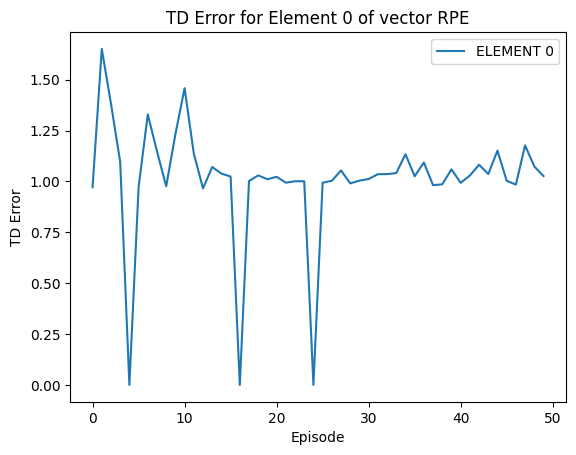

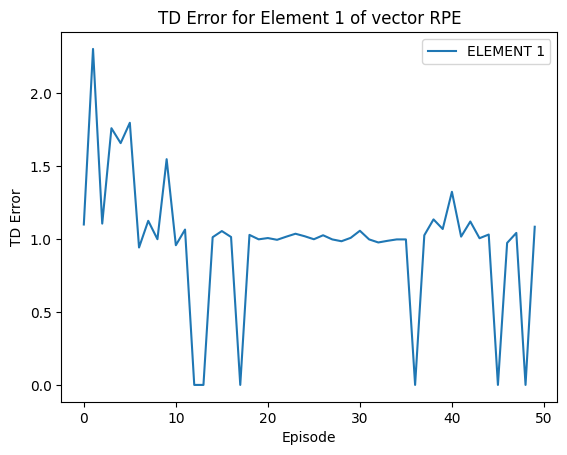

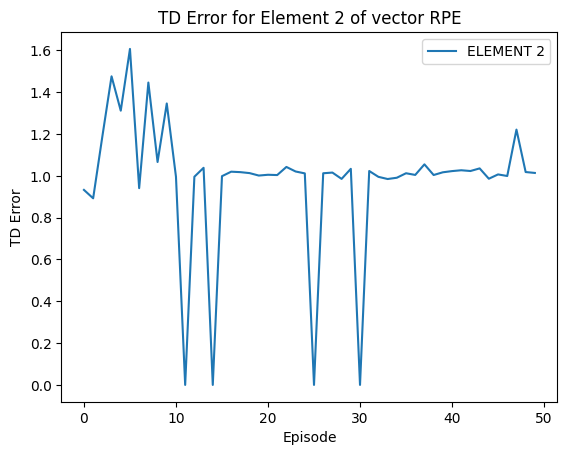

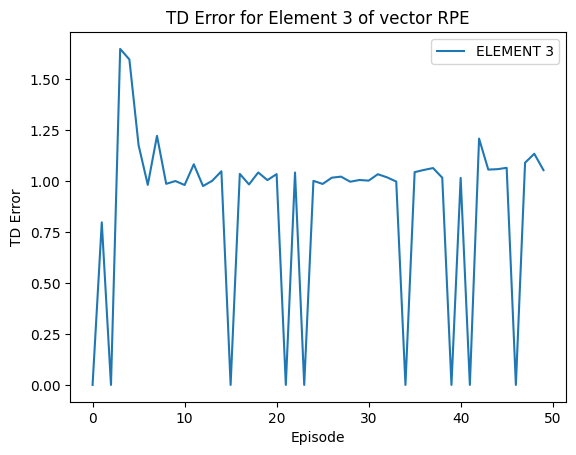

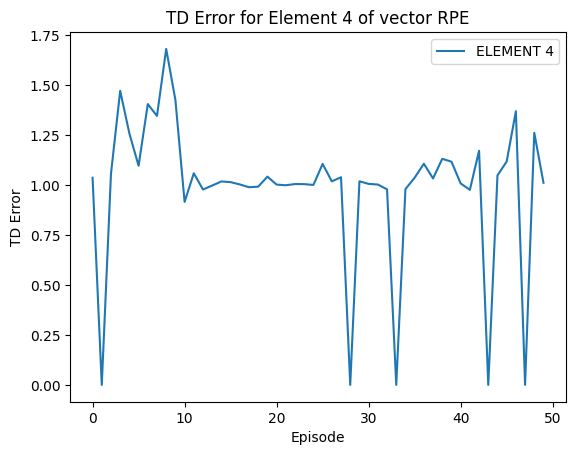

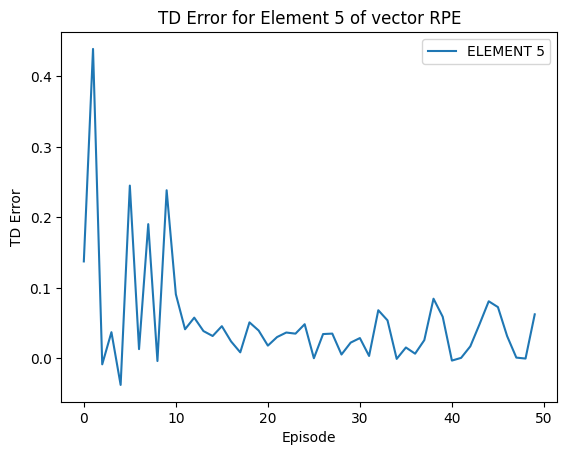

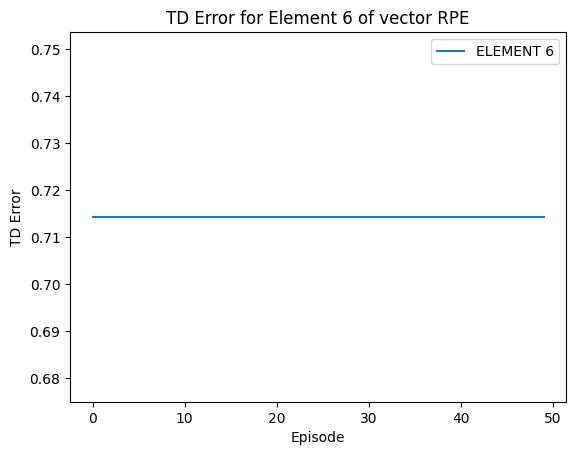

<Figure size 640x480 with 0 Axes>

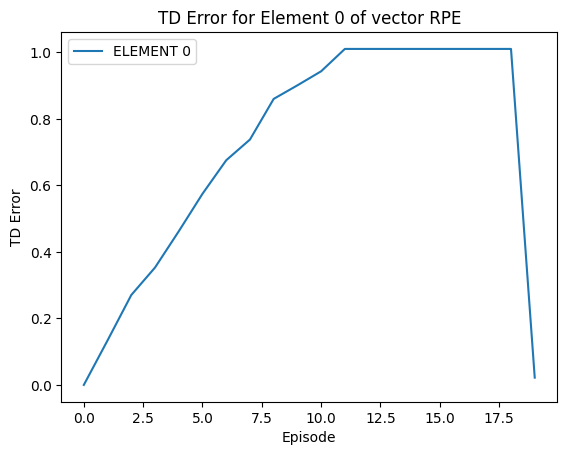

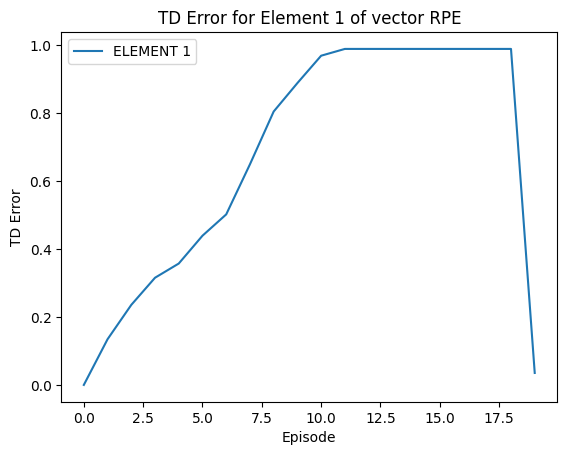

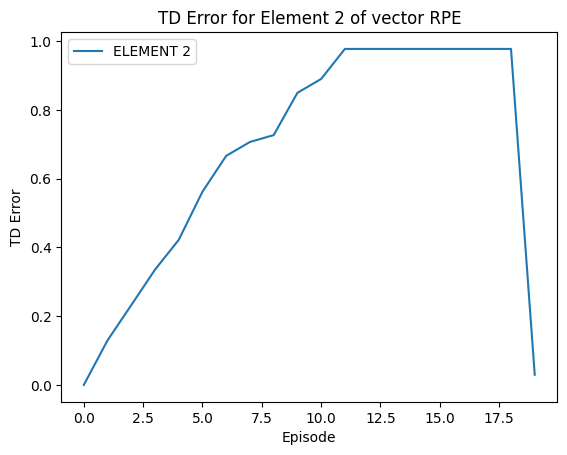

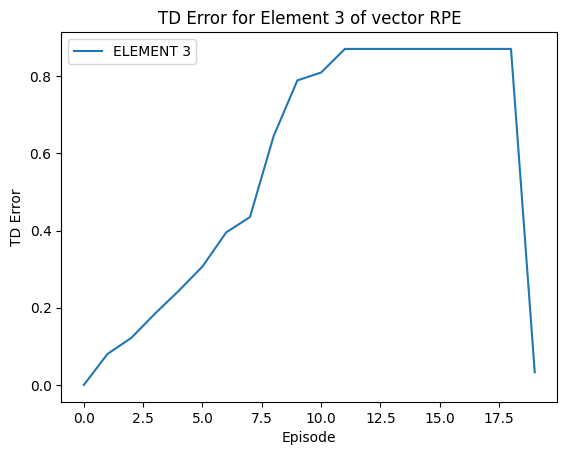

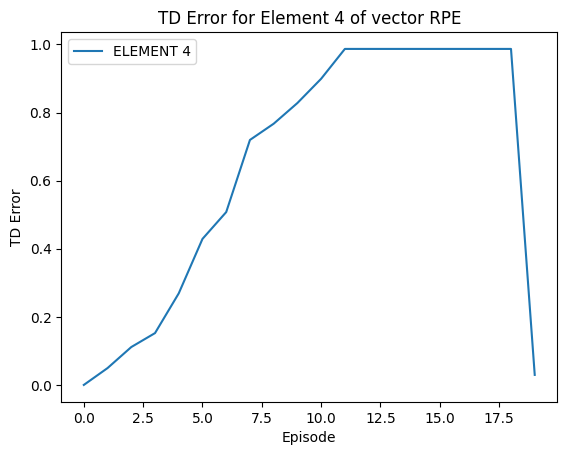

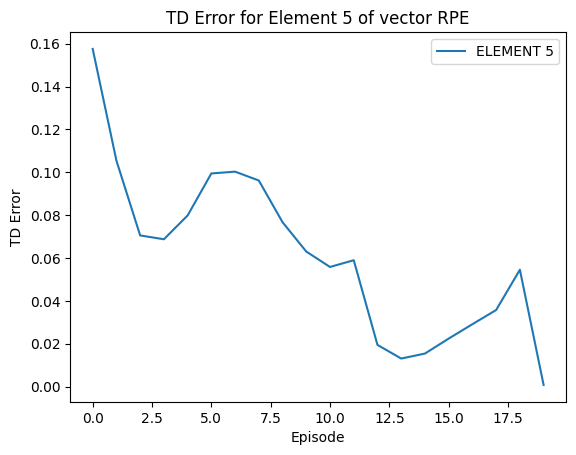

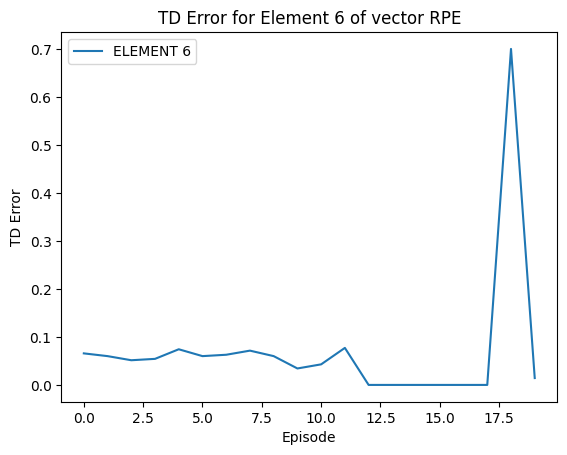

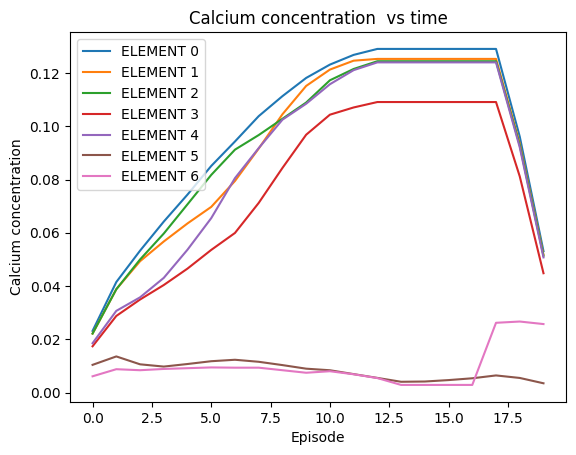

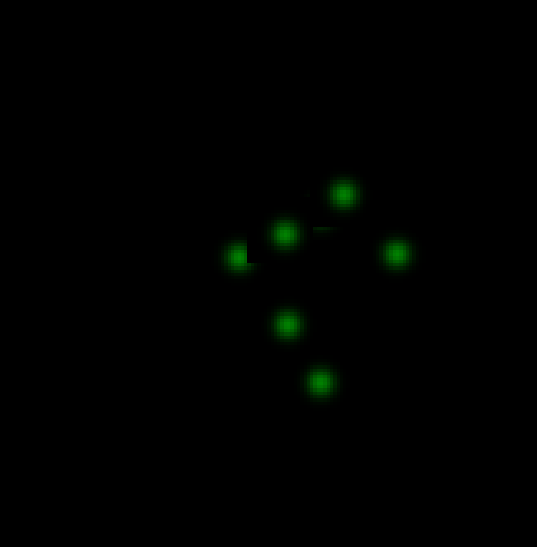

In [16]:
# initialize agent

# Train the agent.THIS MIGHT TAKE A WHILE!!
n_cues_left = 5  # replace with the actual number
n_cues_right = 0  # replace with the actual number
agent.run_episodes(n_cues_left, n_cues_right)

EPISODE 0
1/1 [==============================] - 0s 24ms/step
dim 1
multi td [ 0.          1.05712051  0.          0.          0.          0.
  0.         -0.06828695  0.11111111]
1/1 [==============================] - 0s 21ms/step
dim 4
multi td [ 0.          1.05712051  0.          0.          1.07896817  0.
  0.         -0.12339763  0.11111111]
1/1 [==============================] - 0s 26ms/step
dim 6
multi td [ 0.          1.05712051  0.          0.          1.07896817  0.
 -0.7054412   0.17620878 -0.11111111]
1/1 [==============================] - 0s 22ms/step
dim 0
multi td [ 1.36014628  1.05712051  0.          0.          1.07896817  0.
 -0.7054412   0.33660673  0.11111111]
1/1 [==============================] - 0s 34ms/step
dim 3
multi td [ 1.36014628  1.05712051  0.          1.2258066   1.07896817  0.
 -0.7054412   0.26409338  0.11111111]
1/1 [==============================] - 0s 37ms/step
dim 5
multi td [ 1.36014628  1.05712051  0.          1.2258066   1.07896817 -1.03136729


<Figure size 640x480 with 0 Axes>

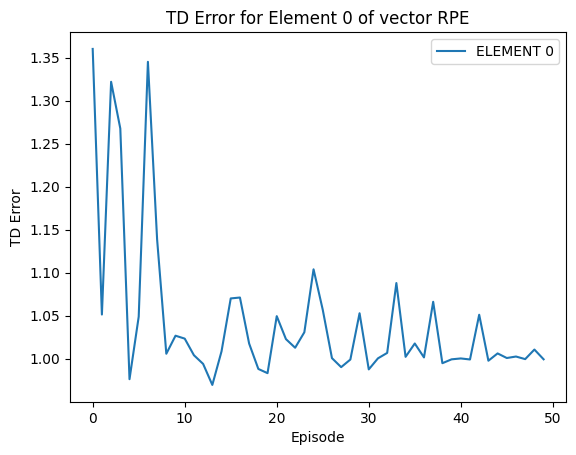

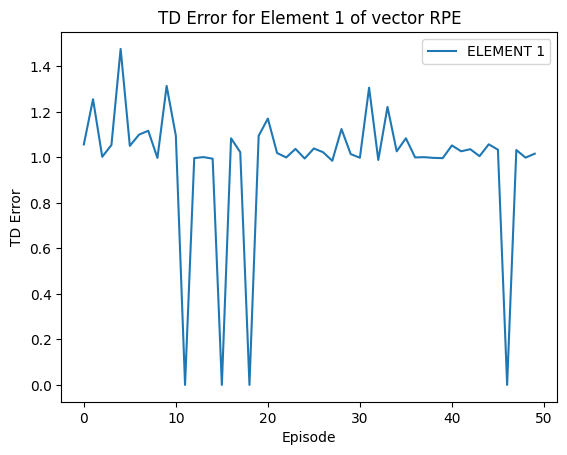

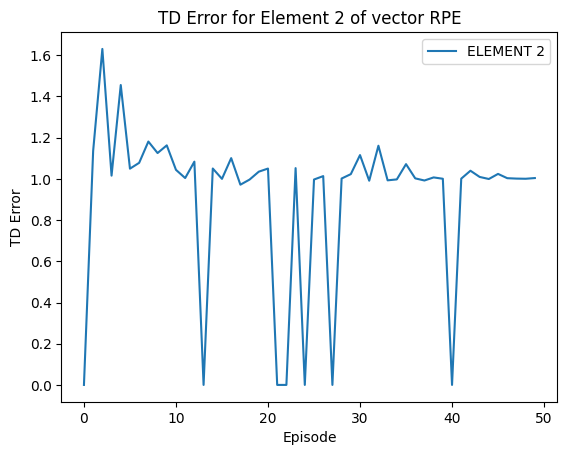

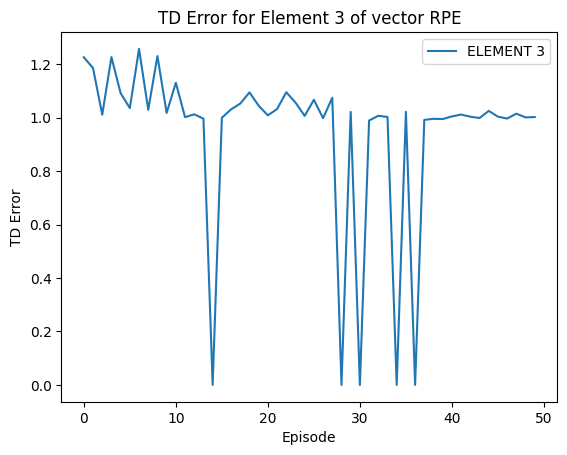

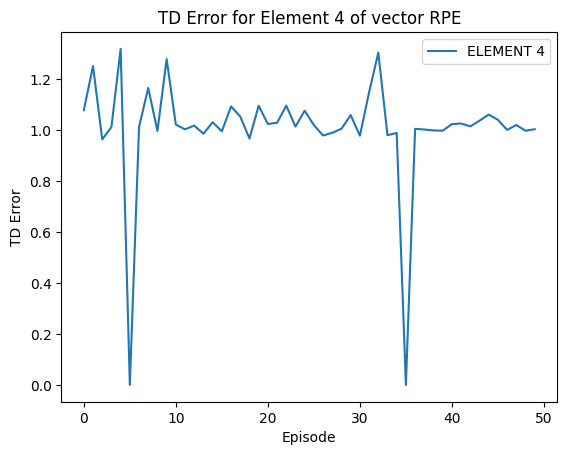

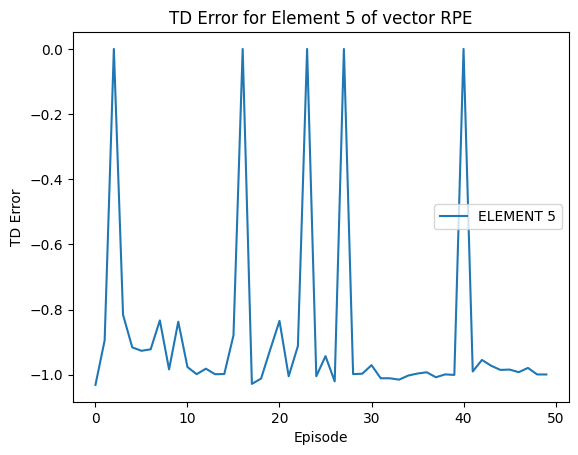

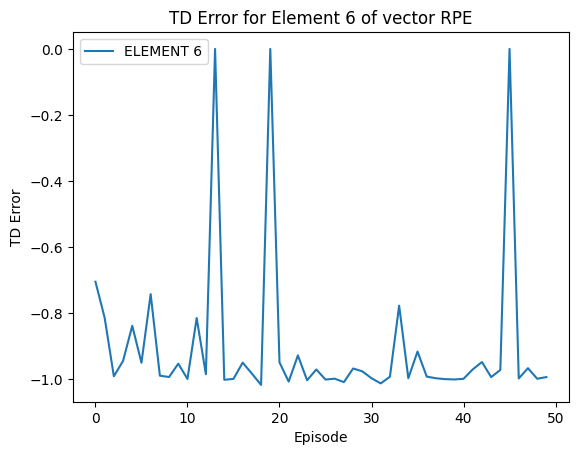

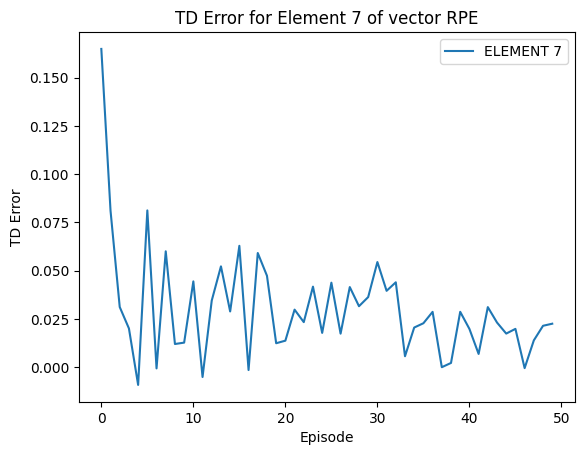

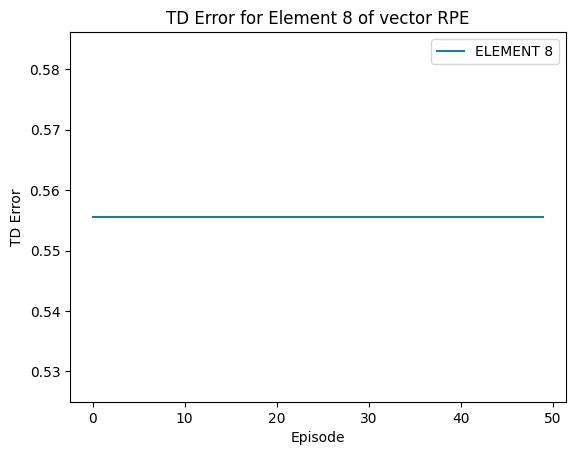

<Figure size 640x480 with 0 Axes>

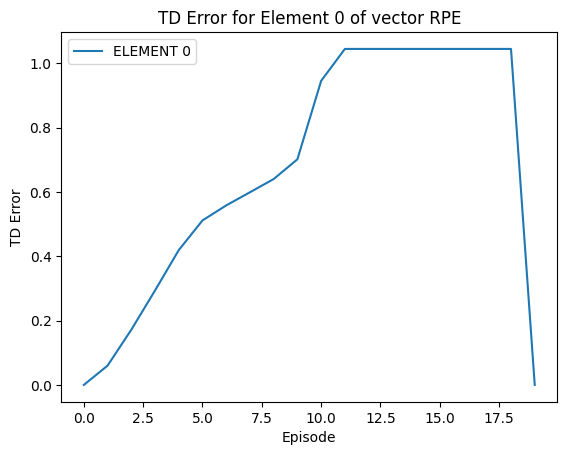

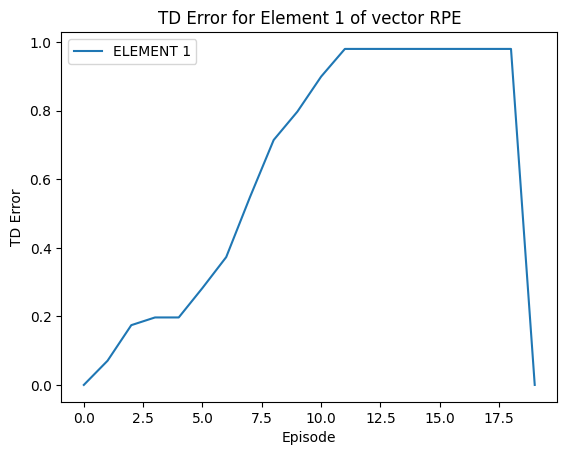

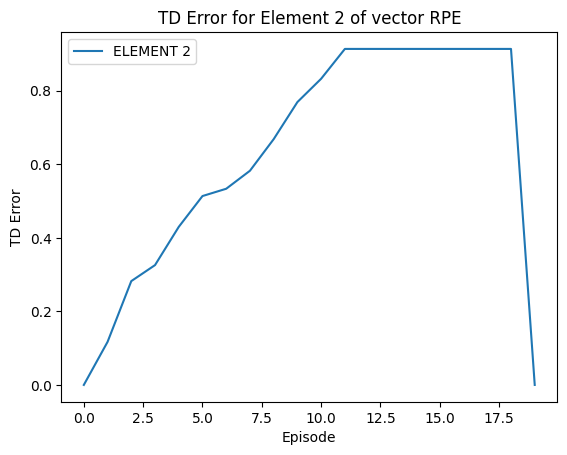

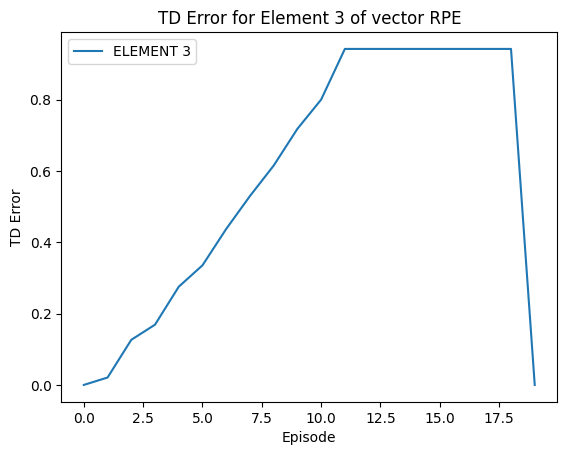

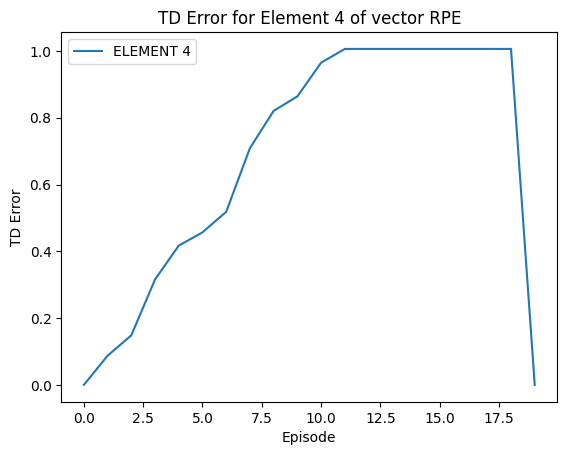

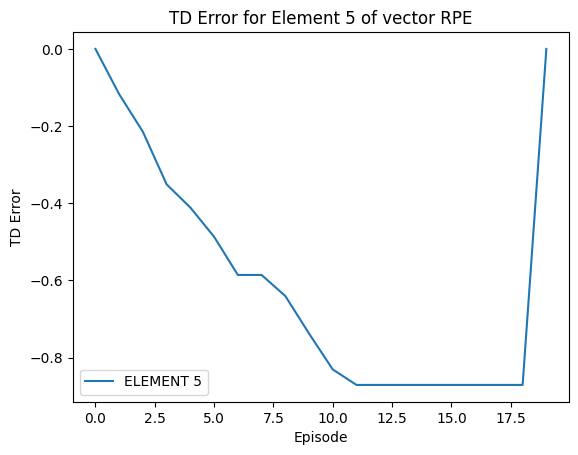

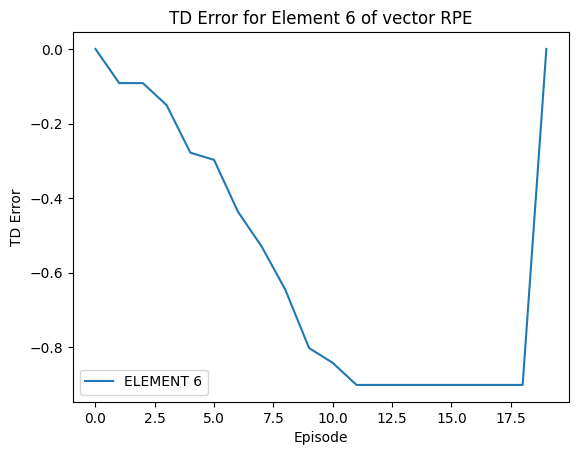

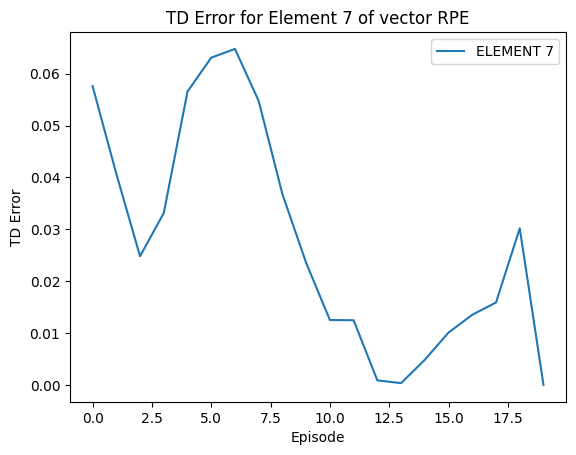

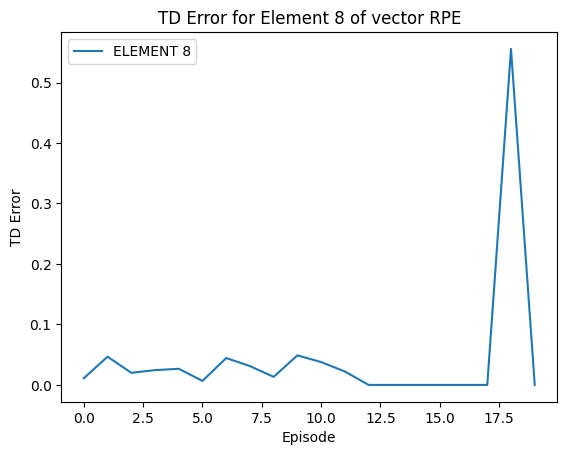

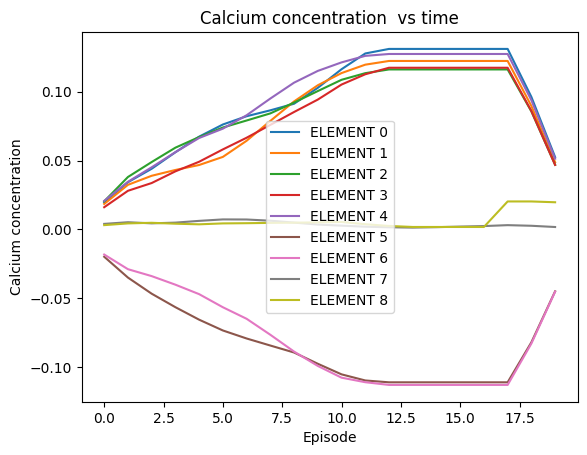

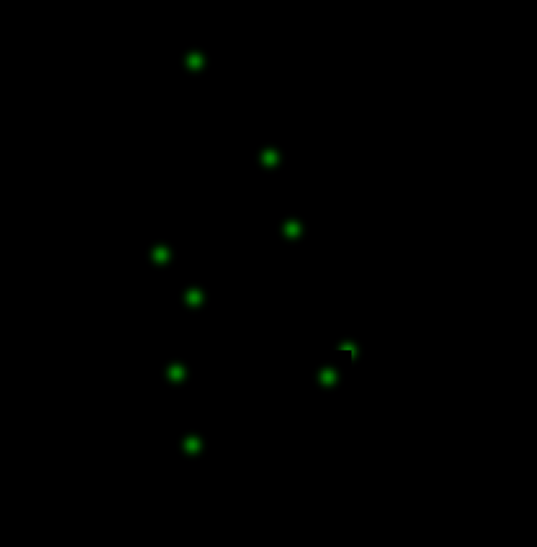

In [17]:
# E MIGHT ALSO TAKE A WHILE
n_cues_left = 5
n_cues_right = 2
agent.run_episodes(n_cues_left, n_cues_right)
